# Exploration and Comparison of Transformers for Image Classification

## Few-Shot Linear Probing using Vision Transformer (ViT)

Linear Probing is an experiment that involes training a linear classifier on top of pre-trained frozen features of the model.

Few-Shot Learning involes showing the model only small number of images per class. For example, showing only 1 image per class makes it a one-shot learning.

For this experiment, **(1, 2, 4, 8, 16)** shots will be used.

### Vision Transformer (ViT)

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. It was introduced in the paper *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al.*

https://arxiv.org/abs/2010.11929

### Prerequisites

Load necessary packages.

In [2]:
import os
os.chdir('../../../')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

Load ViT image processor used for image pre-processing.

In [5]:
processor = get_backbone_processor(model_names['ViT'])

Print the pre-processing operations done by the processor.

In [6]:
processor

ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Data Preprocessing

Load each dataset and its splits.

Processor is automatically applied to each image.

#### RESISC45

In [7]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45_train = ImageDataset(
    dataset=resisc45['train'],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45['validation'],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
)

#### Food-101

In [8]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101_train = ImageDataset(
    dataset=food101['train'],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
)

#### FER2013

In [9]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013_train = ImageDataset(
    dataset=fer2013['train'],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013['valid'],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
)

#### PCam

In [10]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam_train = ImageDataset(
    dataset=pcam['train'],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam['validation'],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
)

#### SUN397

In [11]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397_train = ImageDataset(
    dataset=sun397['train'],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397['validation'],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
)

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

#### DTD

In [13]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd_train = ImageDataset(
    dataset=dtd['train'],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
)

### Config

Create a config for the experiments and print its settings.

In [3]:
config = Config(
    num_epochs=10, 
    lr=1e-3, 
    weight_decay=0
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 0.001,
 'num_epochs': 10,
 'optimizer': torch.optim.adam.Adam,
 'weight_decay': 0,
 'dropout_rate': 0.1,
 'early_stopping': {'enabled': False, 'patience': 3, 'delta': 0},
 'gradient_clipping': {'enabled': False, 'max_norm': 0},
 'scheduler': {'enabled': False,
  'warmup_epochs': 0,
  'eta_min': 0,
  'linear_start_factor': 0.1,
  'linear_end_factor': 1.0}}

Create empty array to store dataset accuracies for each experiment.

In [93]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Few-Shot Linear Probing (n=1)


Model is shown only 1 image per class from the dataset.

#### RESISC45

In [31]:
vit_resisc45_1 = Backbone(model_names['ViT'], num_classes=len(resisc45_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
get_model_params(vit_resisc45_1)

Parameters: 85.83M


In [33]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    vit_resisc45_1,
    resisc45_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 6/6 [00:00<00:00, 12.57it/s]


Epochs: 1/10 | train_loss: 4.4003 | train_acc: 0.0000


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]


Epochs: 2/10 | train_loss: 2.9080 | train_acc: 0.4444


100%|██████████| 6/6 [00:00<00:00, 12.56it/s]


Epochs: 3/10 | train_loss: 1.9216 | train_acc: 0.8667


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]


Epochs: 4/10 | train_loss: 1.1529 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]


Epochs: 5/10 | train_loss: 0.6953 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 12.67it/s]


Epochs: 6/10 | train_loss: 0.4116 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]


Epochs: 7/10 | train_loss: 0.2488 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 12.55it/s]


Epochs: 8/10 | train_loss: 0.1651 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]


Epochs: 9/10 | train_loss: 0.1204 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]

Epochs: 10/10 | train_loss: 0.0913 | train_acc: 1.0000


In [34]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    vit_resisc45_1,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:05<00:00, 12.03it/s]

test_loss: 2.7908 | test_acc: 0.2816


In [94]:
resisc45_accs.append(resisc45_acc)

In [38]:
get_top_5_accuracies(resisc45_per_class_acc)

[('beach', 0.6923076923076923),
 ('stadium', 0.6901408450704225),
 ('sea ice', 0.6887417218543046),
 ('circular farmland', 0.678082191780822),
 ('island', 0.6115107913669064)]

In [39]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('industrial area', 0.007142857142857143),
 ('mobile home park', 0.012195121951219513),
 ('commercial area', 0.02142857142857143),
 ('palace', 0.02857142857142857),
 ('dense residential', 0.034722222222222224)]

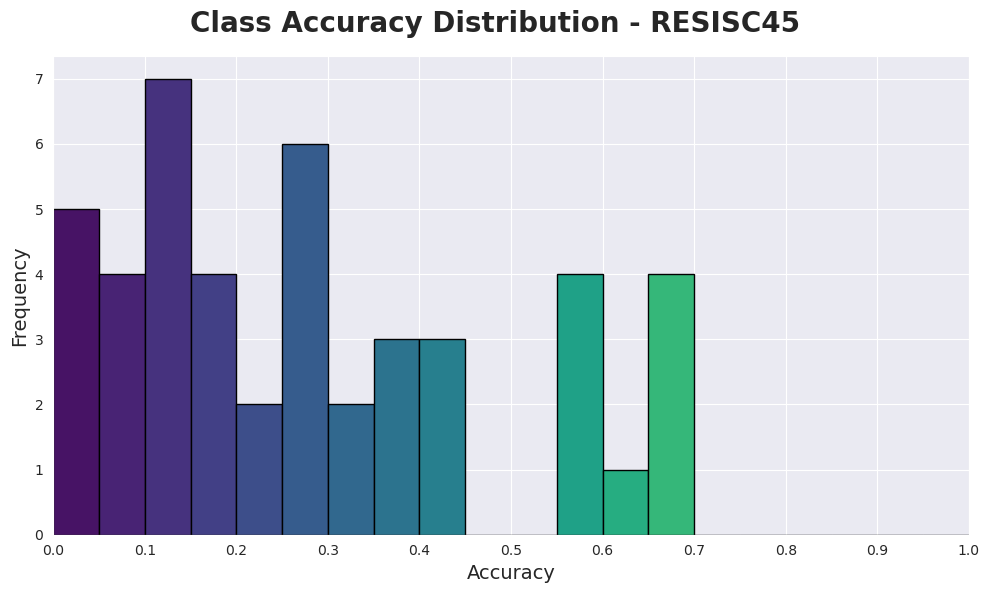

In [40]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [41]:
vit_food101_1 = Backbone(model_names['ViT'], num_classes=len(food101_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
get_model_params(vit_food101_1)

Parameters: 85.88M


In [43]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    vit_food101_1,
    food101_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 13/13 [00:01<00:00,  7.18it/s]


Epochs: 1/10 | train_loss: 5.3169 | train_acc: 0.0198


100%|██████████| 13/13 [00:01<00:00, 10.80it/s]


Epochs: 2/10 | train_loss: 3.0201 | train_acc: 0.6040


100%|██████████| 13/13 [00:01<00:00, 10.85it/s]


Epochs: 3/10 | train_loss: 1.4273 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00, 10.77it/s]


Epochs: 4/10 | train_loss: 0.5355 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00, 10.84it/s]


Epochs: 5/10 | train_loss: 0.2085 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00, 10.89it/s]


Epochs: 6/10 | train_loss: 0.1101 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00, 10.85it/s]


Epochs: 7/10 | train_loss: 0.0754 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00, 10.87it/s]


Epochs: 8/10 | train_loss: 0.0589 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00, 10.87it/s]


Epochs: 9/10 | train_loss: 0.0481 | train_acc: 1.0000


100%|██████████| 13/13 [00:01<00:00, 10.85it/s]

Epochs: 10/10 | train_loss: 0.0410 | train_acc: 1.0000


In [44]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    vit_food101_1,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:02<00:00, 10.43it/s]


test_loss: 2.6728 | test_acc: 0.4051


In [95]:
food101_accs.append(food101_acc)

In [46]:
get_top_5_accuracies(food101_per_class_acc)

[('pizza', 0.984),
 ('edamame', 0.98),
 ('spaghetti carbonara', 0.972),
 ('eggs benedict', 0.924),
 ('clam chowder', 0.892)]

In [47]:
get_bottom_5_accuracies(food101_per_class_acc)

[('dumplings', 0.0),
 ('gyoza', 0.0),
 ('scallops', 0.0),
 ('breakfast burrito', 0.004),
 ('chocolate cake', 0.004)]

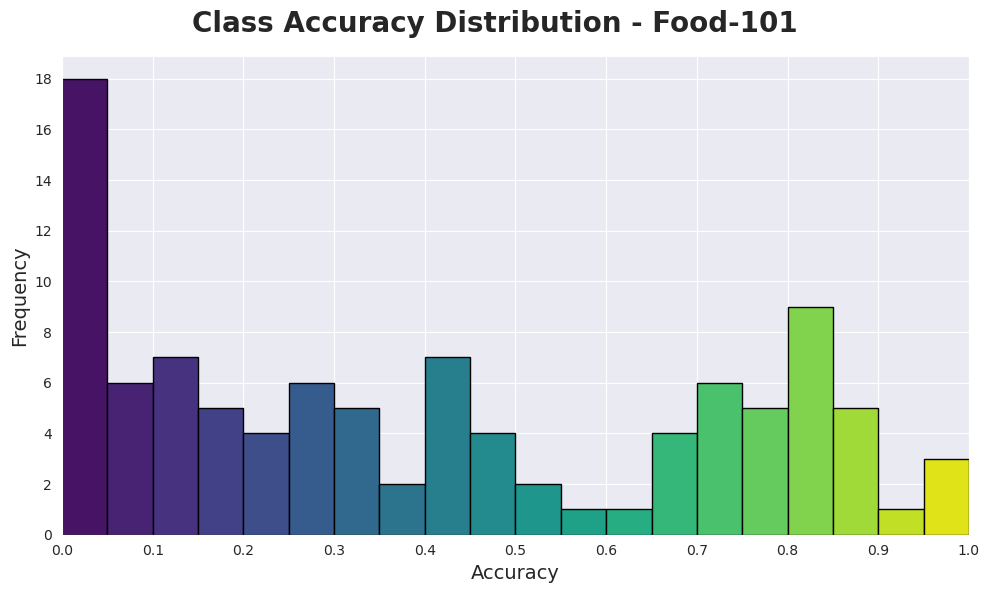

In [48]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [49]:
vit_fer2013_1 = Backbone(model_names['ViT'], num_classes=len(fer2013_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
get_model_params(vit_fer2013_1)

Parameters: 85.80M


In [51]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    vit_fer2013_1,
    fer2013_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


Epochs: 1/10 | train_loss: 1.7337 | train_acc: 0.1429


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Epochs: 2/10 | train_loss: 1.3844 | train_acc: 0.8571


100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


Epochs: 3/10 | train_loss: 1.0855 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


Epochs: 4/10 | train_loss: 0.8360 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epochs: 5/10 | train_loss: 0.6328 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


Epochs: 6/10 | train_loss: 0.4719 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


Epochs: 7/10 | train_loss: 0.3485 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


Epochs: 8/10 | train_loss: 0.2567 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


Epochs: 9/10 | train_loss: 0.1898 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 13.77it/s]

Epochs: 10/10 | train_loss: 0.1418 | train_acc: 1.0000


In [52]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    vit_fer2013_1,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:34<00:00, 12.85it/s]

test_loss: 1.7907 | test_acc: 0.3087


In [96]:
fer2013_accs.append(fer2013_acc)

In [55]:
fer2013_per_class_acc

{'angry': 0.1364562118126273,
 'disgust': 0.05454545454545454,
 'fear': 0.2859848484848485,
 'happy': 0.6507394766780432,
 'sad': 0.11447811447811448,
 'surprise': 0.3076923076923077,
 'neutral': 0.1900958466453674}

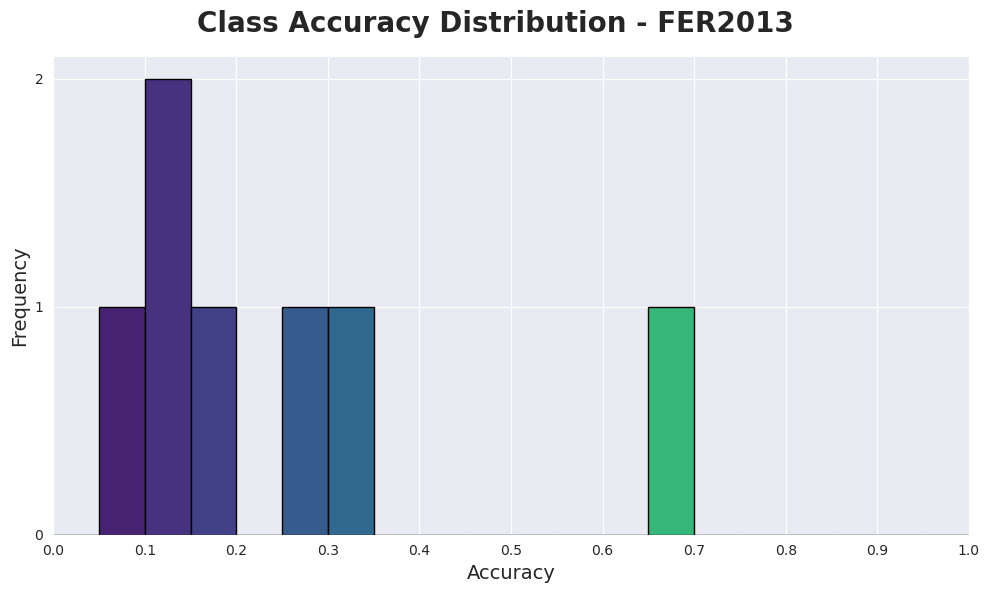

In [56]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [57]:
vit_pcam_1 = Backbone(model_names['ViT'], num_classes=len(pcam_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
get_model_params(vit_pcam_1)

Parameters: 85.80M


In [59]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    vit_pcam_1,
    pcam_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 1/1 [00:00<00:00, 39.62it/s]


Epochs: 1/10 | train_loss: 0.7753 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00, 41.75it/s]


Epochs: 2/10 | train_loss: 0.5750 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 42.12it/s]


Epochs: 3/10 | train_loss: 0.4190 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 37.30it/s]


Epochs: 4/10 | train_loss: 0.3006 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 42.86it/s]


Epochs: 5/10 | train_loss: 0.2149 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 42.52it/s]


Epochs: 6/10 | train_loss: 0.1543 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


Epochs: 7/10 | train_loss: 0.1117 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 43.03it/s]


Epochs: 8/10 | train_loss: 0.0819 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 42.83it/s]


Epochs: 9/10 | train_loss: 0.0611 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 42.58it/s]

Epochs: 10/10 | train_loss: 0.0464 | train_acc: 1.0000


In [60]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    vit_pcam_1,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [05:22<00:00, 12.68it/s]

test_loss: 1.1620 | test_acc: 0.3023


In [97]:
pcam_accs.append(pcam_acc)

In [62]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.44310902324446344,
 'lymph node tumor tissue': 0.16132380777920255}

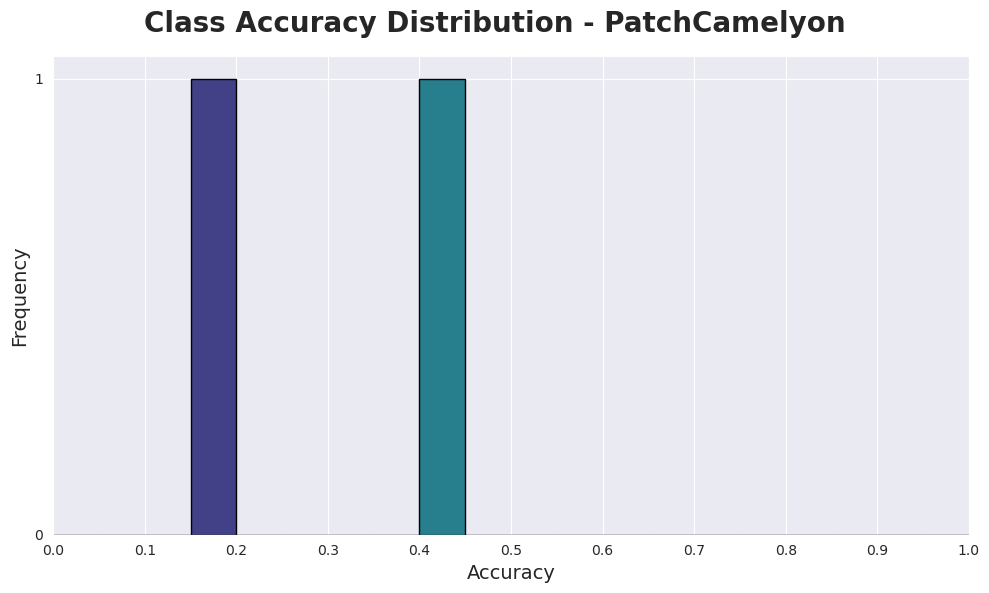

In [63]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [64]:
vit_sun397_1 = Backbone(model_names['ViT'], num_classes=len(sun397_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
get_model_params(vit_sun397_1)

Parameters: 86.10M


In [66]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    vit_sun397_1,
    sun397_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 50/50 [00:05<00:00,  9.33it/s]


Epochs: 1/10 | train_loss: 6.8647 | train_acc: 0.0000


100%|██████████| 50/50 [00:05<00:00,  9.95it/s]


Epochs: 2/10 | train_loss: 2.9989 | train_acc: 0.7935


100%|██████████| 50/50 [00:05<00:00,  9.95it/s]


Epochs: 3/10 | train_loss: 0.5747 | train_acc: 0.9899


100%|██████████| 50/50 [00:05<00:00,  9.95it/s]


Epochs: 4/10 | train_loss: 0.1284 | train_acc: 1.0000


100%|██████████| 50/50 [00:05<00:00,  9.93it/s]


Epochs: 5/10 | train_loss: 0.0711 | train_acc: 1.0000


100%|██████████| 50/50 [00:05<00:00,  9.92it/s]


Epochs: 6/10 | train_loss: 0.0496 | train_acc: 1.0000


100%|██████████| 50/50 [00:05<00:00,  9.97it/s]


Epochs: 7/10 | train_loss: 0.0372 | train_acc: 1.0000


100%|██████████| 50/50 [00:05<00:00,  9.95it/s]


Epochs: 8/10 | train_loss: 0.0297 | train_acc: 1.0000


100%|██████████| 50/50 [00:05<00:00,  9.91it/s]


Epochs: 9/10 | train_loss: 0.0244 | train_acc: 1.0000


100%|██████████| 50/50 [00:05<00:00,  9.94it/s]

Epochs: 10/10 | train_loss: 0.0205 | train_acc: 1.0000


In [67]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    vit_sun397_1,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [04:37<00:00,  9.81it/s]


test_loss: 2.7986 | test_acc: 0.4278


In [98]:
sun397_accs.append(sun397_acc)

In [69]:
get_top_5_accuracies(sun397_per_class_acc)

[('nursery', 1.0),
 ('oast house', 1.0),
 ('raft', 1.0),
 ('rock arch', 1.0),
 ('oilrig', 0.9833333333333333)]

In [70]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('burial chamber', 0.0),
 ('candy store', 0.0),
 ('castle', 0.0),
 ('cathedral (outdoor)', 0.0),
 ('childs room', 0.0)]

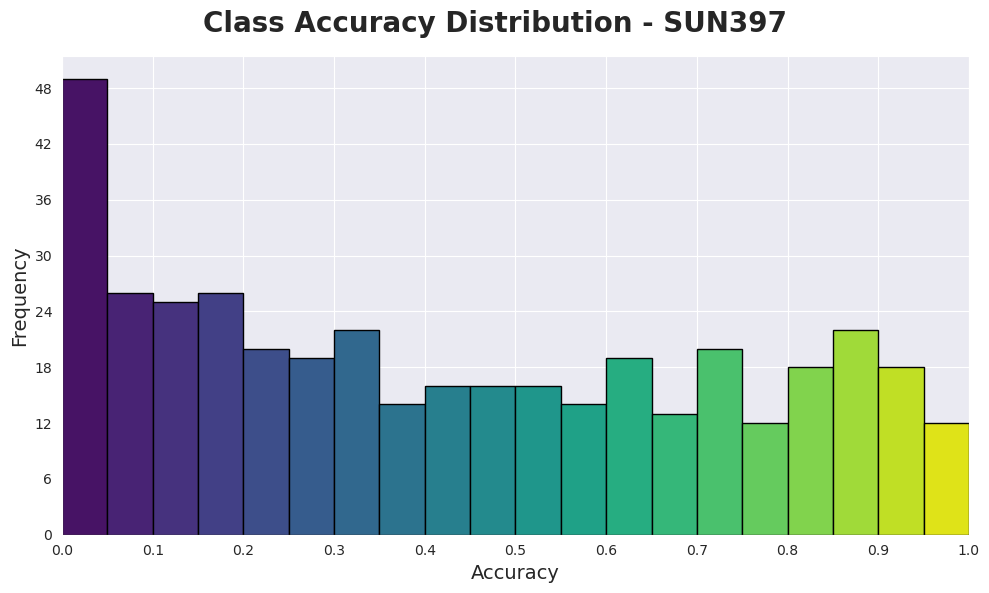

In [71]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [85]:
vit_dtd_1 = Backbone(model_names['ViT'], num_classes=len(dtd_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
get_model_params(vit_dtd_1)

Parameters: 85.83M


In [87]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    vit_dtd_1,
    dtd_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=1
)

100%|██████████| 6/6 [00:00<00:00,  9.64it/s]


Epochs: 1/10 | train_loss: 4.1814 | train_acc: 0.0000


100%|██████████| 6/6 [00:00<00:00,  9.72it/s]


Epochs: 2/10 | train_loss: 2.7011 | train_acc: 0.5319


100%|██████████| 6/6 [00:00<00:00,  9.63it/s]


Epochs: 3/10 | train_loss: 1.5868 | train_acc: 0.9362


100%|██████████| 6/6 [00:00<00:00,  9.84it/s]


Epochs: 4/10 | train_loss: 0.7672 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  9.83it/s]


Epochs: 5/10 | train_loss: 0.3464 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  9.78it/s]


Epochs: 6/10 | train_loss: 0.1674 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  9.84it/s]


Epochs: 7/10 | train_loss: 0.0936 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  9.85it/s]


Epochs: 8/10 | train_loss: 0.0629 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  9.71it/s]


Epochs: 9/10 | train_loss: 0.0458 | train_acc: 1.0000


100%|██████████| 6/6 [00:00<00:00,  9.72it/s]

Epochs: 10/10 | train_loss: 0.0373 | train_acc: 1.0000


In [88]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    vit_dtd_1,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:22<00:00, 10.30it/s]

test_loss: 3.1055 | test_acc: 0.2702


In [99]:
dtd_accs.append(dtd_acc)

In [90]:
get_top_5_accuracies(dtd_per_class_acc)

[('cobwebbed', 0.925),
 ('potholed', 0.9),
 ('lacelike', 0.725),
 ('dotted', 0.625),
 ('perforated', 0.6)]

In [91]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('grooved', 0.0),
 ('waffled', 0.0),
 ('chequered', 0.025),
 ('honeycombed', 0.025),
 ('smeared', 0.025)]

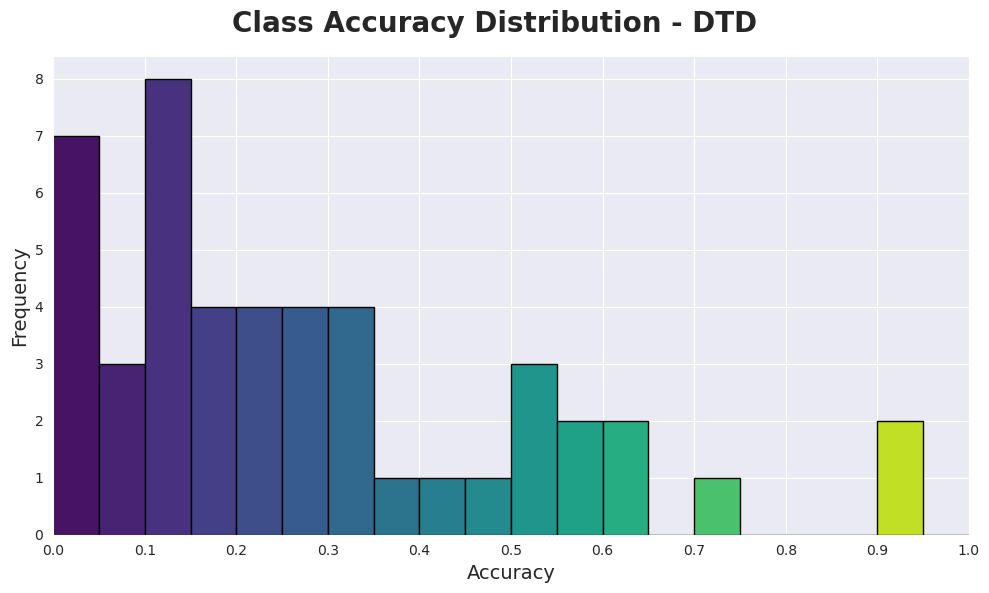

In [92]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=2)


Model is shown only 2 images per class from the dataset.

#### RESISC45

In [106]:
vit_resisc45_2 = Backbone(model_names['ViT'], num_classes=len(resisc45_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [107]:
get_model_params(vit_resisc45_2)

Parameters: 85.83M


In [108]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    vit_resisc45_2,
    resisc45_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 12/12 [00:00<00:00, 12.70it/s]


Epochs: 1/10 | train_loss: 4.1261 | train_acc: 0.0333


100%|██████████| 12/12 [00:00<00:00, 12.72it/s]


Epochs: 2/10 | train_loss: 2.3578 | train_acc: 0.6111


100%|██████████| 12/12 [00:00<00:00, 12.83it/s]


Epochs: 3/10 | train_loss: 1.4758 | train_acc: 0.9222


100%|██████████| 12/12 [00:00<00:00, 12.62it/s]


Epochs: 4/10 | train_loss: 0.8622 | train_acc: 1.0000


100%|██████████| 12/12 [00:00<00:00, 12.74it/s]


Epochs: 5/10 | train_loss: 0.5394 | train_acc: 1.0000


100%|██████████| 12/12 [00:00<00:00, 12.75it/s]


Epochs: 6/10 | train_loss: 0.3524 | train_acc: 1.0000


100%|██████████| 12/12 [00:00<00:00, 12.69it/s]


Epochs: 7/10 | train_loss: 0.2471 | train_acc: 1.0000


100%|██████████| 12/12 [00:00<00:00, 12.53it/s]


Epochs: 8/10 | train_loss: 0.1874 | train_acc: 1.0000


100%|██████████| 12/12 [00:00<00:00, 12.62it/s]


Epochs: 9/10 | train_loss: 0.1481 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00, 11.82it/s]

Epochs: 10/10 | train_loss: 0.1179 | train_acc: 1.0000


In [109]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    vit_resisc45_2,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:04<00:00, 12.13it/s]

test_loss: 2.3008 | test_acc: 0.3867


In [110]:
resisc45_accs.append(resisc45_acc)

In [112]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.8874172185430463),
 ('overpass', 0.8533333333333334),
 ('beach', 0.7615384615384615),
 ('stadium', 0.7605633802816901),
 ('bridge', 0.7142857142857143)]

In [113]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.05714285714285714),
 ('church', 0.07692307692307693),
 ('industrial area', 0.07857142857142857),
 ('dense residential', 0.11805555555555555),
 ('basketball court', 0.11940298507462686)]

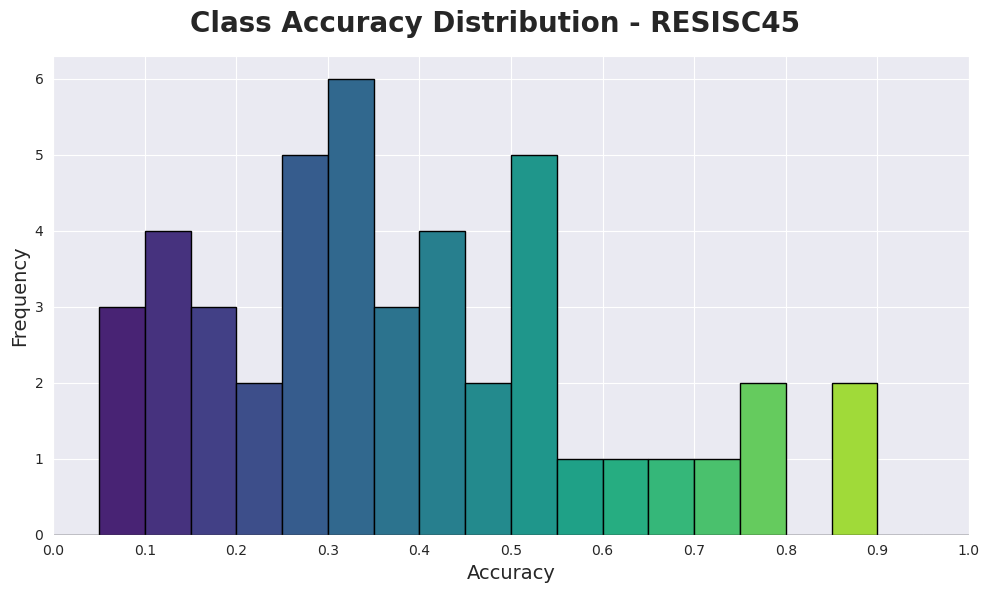

In [114]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [115]:
vit_food101_2 = Backbone(model_names['ViT'], num_classes=len(food101_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [116]:
get_model_params(vit_food101_2)

Parameters: 85.88M


In [117]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    vit_food101_2,
    food101_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 26/26 [00:02<00:00, 10.57it/s]


Epochs: 1/10 | train_loss: 5.0144 | train_acc: 0.0297


100%|██████████| 26/26 [00:02<00:00, 10.68it/s]


Epochs: 2/10 | train_loss: 2.2891 | train_acc: 0.8366


100%|██████████| 26/26 [00:02<00:00, 10.69it/s]


Epochs: 3/10 | train_loss: 0.8964 | train_acc: 0.9950


100%|██████████| 26/26 [00:02<00:00, 10.66it/s]


Epochs: 4/10 | train_loss: 0.3340 | train_acc: 1.0000


100%|██████████| 26/26 [00:02<00:00, 10.60it/s]


Epochs: 5/10 | train_loss: 0.1674 | train_acc: 1.0000


100%|██████████| 26/26 [00:02<00:00, 10.28it/s]


Epochs: 6/10 | train_loss: 0.1103 | train_acc: 1.0000


100%|██████████| 26/26 [00:02<00:00, 10.66it/s]


Epochs: 7/10 | train_loss: 0.0800 | train_acc: 1.0000


100%|██████████| 26/26 [00:02<00:00, 10.66it/s]


Epochs: 8/10 | train_loss: 0.0618 | train_acc: 1.0000


100%|██████████| 26/26 [00:02<00:00, 10.63it/s]


Epochs: 9/10 | train_loss: 0.0505 | train_acc: 1.0000


100%|██████████| 26/26 [00:02<00:00, 10.64it/s]

Epochs: 10/10 | train_loss: 0.0419 | train_acc: 1.0000


In [118]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    vit_food101_2,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:02<00:00, 10.42it/s]

test_loss: 1.9394 | test_acc: 0.5364


In [119]:
food101_accs.append(food101_acc)

In [120]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.984),
 ('pizza', 0.976),
 ('clam chowder', 0.96),
 ('guacamole', 0.94),
 ('spaghetti bolognese', 0.94)]

In [121]:
get_bottom_5_accuracies(food101_per_class_acc)

[('french fries', 0.064),
 ('chocolate cake', 0.068),
 ('panna cotta', 0.072),
 ('huevos rancheros', 0.076),
 ('beet salad', 0.096)]

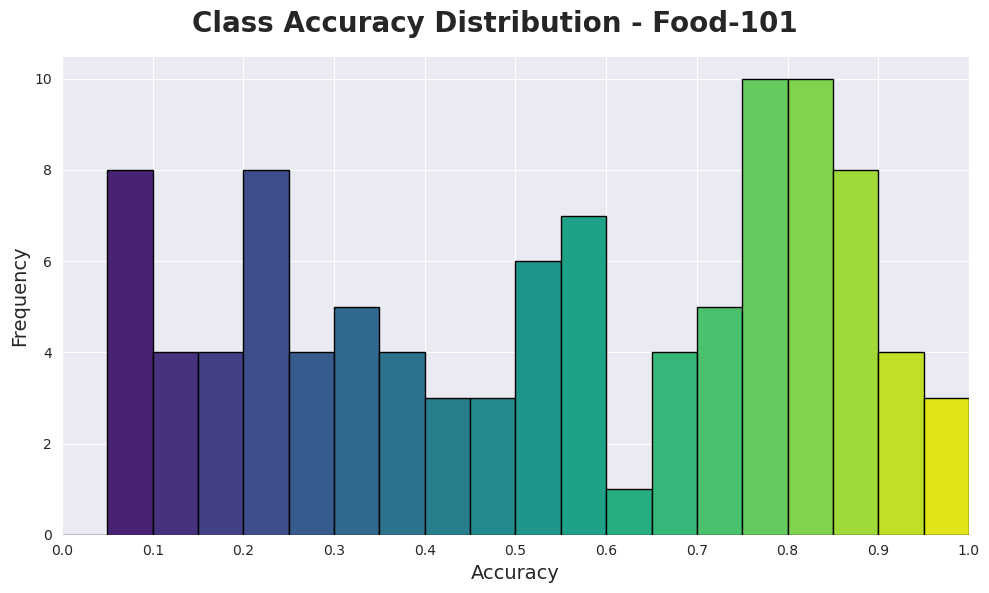

In [122]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [124]:
vit_fer2013_2 = Backbone(model_names['ViT'], num_classes=len(fer2013_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [125]:
get_model_params(vit_fer2013_2)

Parameters: 85.80M


In [126]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    vit_fer2013_2,
    fer2013_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 2/2 [00:00<00:00, 14.01it/s]


Epochs: 1/10 | train_loss: 2.0101 | train_acc: 0.0714


100%|██████████| 2/2 [00:00<00:00, 14.13it/s]


Epochs: 2/10 | train_loss: 1.6052 | train_acc: 0.4286


100%|██████████| 2/2 [00:00<00:00, 14.24it/s]


Epochs: 3/10 | train_loss: 1.3167 | train_acc: 0.8571


100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epochs: 4/10 | train_loss: 1.0568 | train_acc: 0.9286


100%|██████████| 2/2 [00:00<00:00, 14.37it/s]


Epochs: 5/10 | train_loss: 0.8837 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epochs: 6/10 | train_loss: 0.7236 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


Epochs: 7/10 | train_loss: 0.6045 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 14.38it/s]


Epochs: 8/10 | train_loss: 0.4917 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 14.38it/s]


Epochs: 9/10 | train_loss: 0.4056 | train_acc: 1.0000


100%|██████████| 2/2 [00:00<00:00, 14.36it/s]

Epochs: 10/10 | train_loss: 0.3278 | train_acc: 1.0000


In [127]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    vit_fer2013_2,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:34<00:00, 12.96it/s]

test_loss: 1.8149 | test_acc: 0.3096


In [128]:
fer2013_accs.append(fer2013_acc)

In [129]:
fer2013_per_class_acc

{'angry': 0.1975560081466395,
 'disgust': 0.12727272727272726,
 'fear': 0.1875,
 'happy': 0.5278725824800911,
 'sad': 0.3872053872053872,
 'surprise': 0.2980769230769231,
 'neutral': 0.14376996805111822}

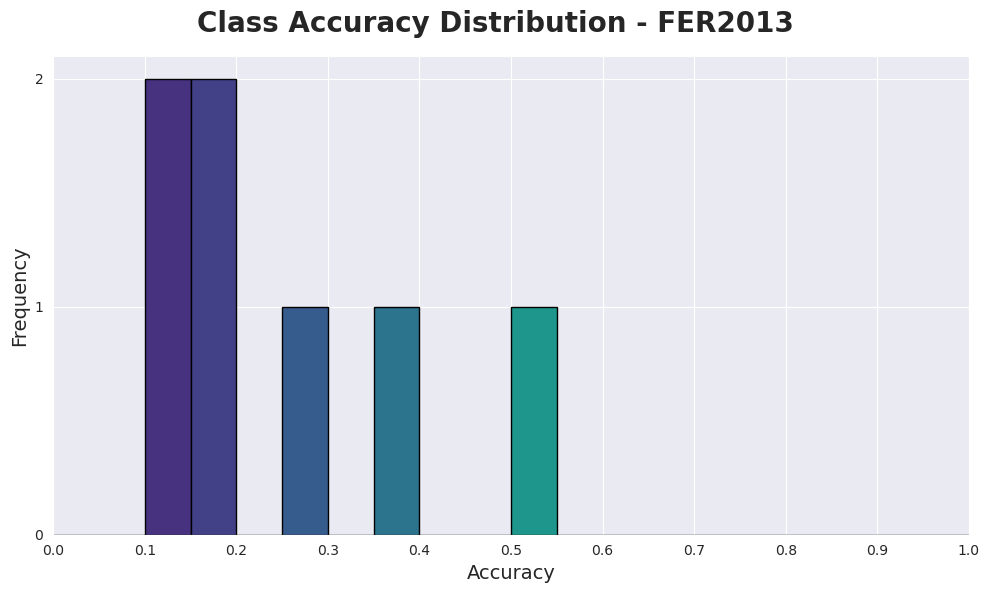

In [130]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [132]:
vit_pcam_2 = Backbone(model_names['ViT'], num_classes=len(pcam_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [134]:
get_model_params(vit_pcam_2)

Parameters: 85.80M


In [135]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    vit_pcam_2,
    pcam_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 1/1 [00:00<00:00, 21.69it/s]


Epochs: 1/10 | train_loss: 0.6273 | train_acc: 0.7500


100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


Epochs: 2/10 | train_loss: 0.5041 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


Epochs: 3/10 | train_loss: 0.4019 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 23.10it/s]


Epochs: 4/10 | train_loss: 0.3184 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 22.98it/s]


Epochs: 5/10 | train_loss: 0.2519 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


Epochs: 6/10 | train_loss: 0.1990 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 23.22it/s]


Epochs: 7/10 | train_loss: 0.1576 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


Epochs: 8/10 | train_loss: 0.1257 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


Epochs: 9/10 | train_loss: 0.1010 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 23.01it/s]

Epochs: 10/10 | train_loss: 0.0817 | train_acc: 1.0000


In [136]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    vit_pcam_2,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [05:19<00:00, 12.80it/s]

test_loss: 1.2752 | test_acc: 0.3727


In [137]:
pcam_accs.append(pcam_acc)

In [140]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.5047282045024709,
 'lymph node tumor tissue': 0.24064236429138425}

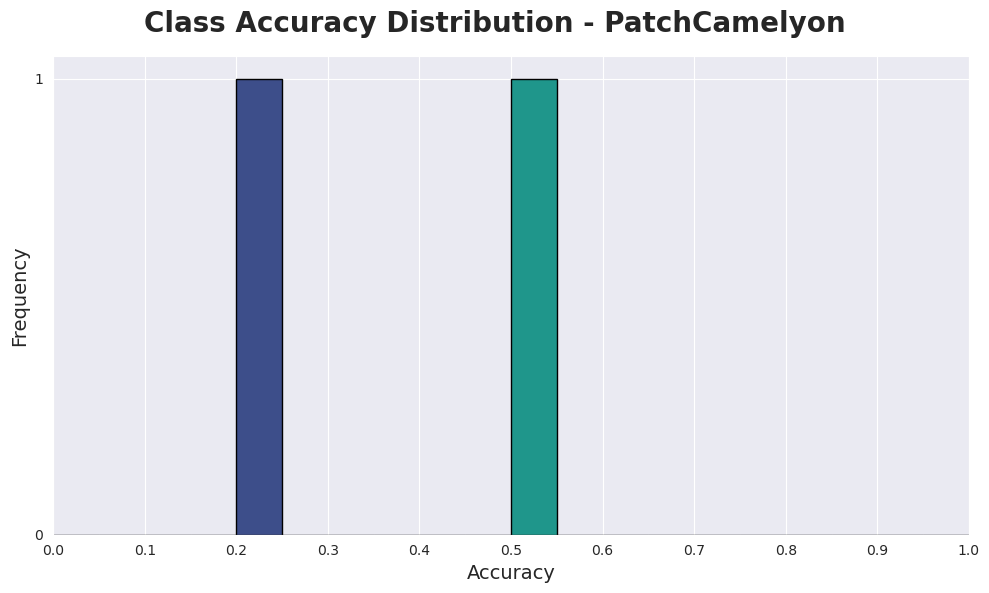

In [141]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [142]:
vit_sun397_2 = Backbone(model_names['ViT'], num_classes=len(sun397_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [143]:
get_model_params(vit_sun397_2)

Parameters: 86.10M


In [144]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    vit_sun397_2,
    sun397_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


Epochs: 1/10 | train_loss: 6.2155 | train_acc: 0.0479


100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


Epochs: 2/10 | train_loss: 1.7007 | train_acc: 0.8426


100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


Epochs: 3/10 | train_loss: 0.2442 | train_acc: 0.9836


100%|██████████| 100/100 [00:10<00:00, 10.00it/s]


Epochs: 4/10 | train_loss: 0.0941 | train_acc: 0.9975


100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


Epochs: 5/10 | train_loss: 0.0564 | train_acc: 0.9975


100%|██████████| 100/100 [00:09<00:00, 10.00it/s]


Epochs: 6/10 | train_loss: 0.0383 | train_acc: 1.0000


100%|██████████| 100/100 [00:10<00:00, 10.00it/s]


Epochs: 7/10 | train_loss: 0.0289 | train_acc: 1.0000


100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


Epochs: 8/10 | train_loss: 0.0231 | train_acc: 1.0000


100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


Epochs: 9/10 | train_loss: 0.0190 | train_acc: 1.0000


100%|██████████| 100/100 [00:10<00:00,  9.75it/s]

Epochs: 10/10 | train_loss: 0.0160 | train_acc: 1.0000


In [145]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    vit_sun397_2,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [04:35<00:00,  9.87it/s]


test_loss: 1.9555 | test_acc: 0.5343


In [147]:
sun397_accs.append(sun397_acc)

In [151]:
get_top_5_accuracies(sun397_per_class_acc)

[('batters box', 1.0),
 ('bullring', 1.0),
 ('greenhouse (outdoor)', 1.0),
 ('nursery', 1.0),
 ('oast house', 1.0)]

In [152]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('building facade', 0.0),
 ('canal (natural)', 0.0),
 ('candy store', 0.0),
 ('nuclear power plant (outdoor)', 0.0),
 ('park', 0.0)]

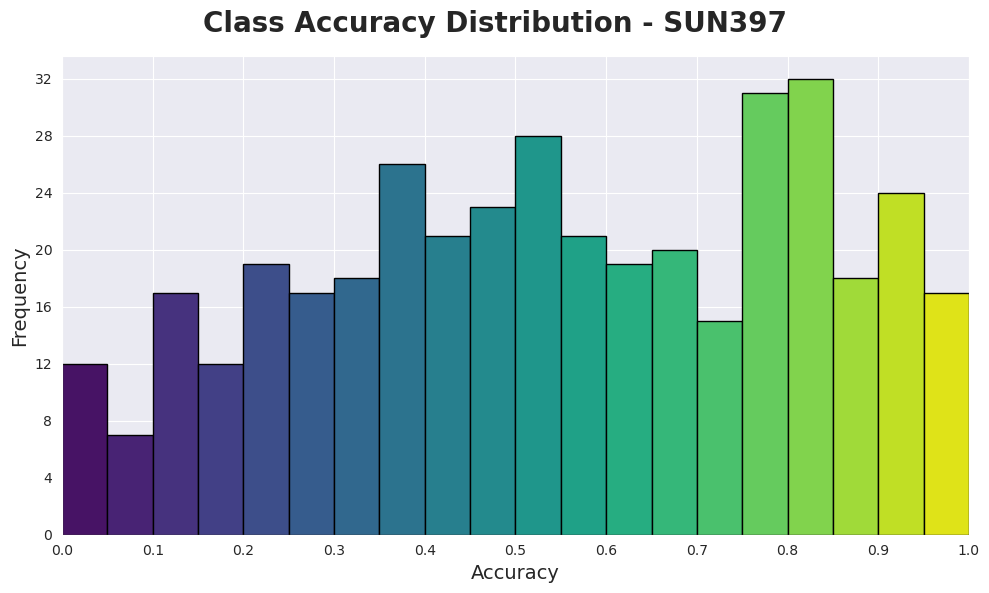

In [153]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [154]:
vit_dtd_2 = Backbone(model_names['ViT'], num_classes=len(dtd_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [155]:
get_model_params(vit_dtd_2)

Parameters: 85.83M


In [156]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    vit_dtd_2,
    dtd_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=2
)

100%|██████████| 12/12 [00:01<00:00,  9.66it/s]


Epochs: 1/10 | train_loss: 4.1121 | train_acc: 0.0000


100%|██████████| 12/12 [00:01<00:00,  9.90it/s]


Epochs: 2/10 | train_loss: 2.3676 | train_acc: 0.6702


100%|██████████| 12/12 [00:01<00:00,  9.87it/s]


Epochs: 3/10 | train_loss: 1.1732 | train_acc: 0.9787


100%|██████████| 12/12 [00:01<00:00,  9.80it/s]


Epochs: 4/10 | train_loss: 0.5058 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  9.78it/s]


Epochs: 5/10 | train_loss: 0.2387 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  9.81it/s]


Epochs: 6/10 | train_loss: 0.1365 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  9.75it/s]


Epochs: 7/10 | train_loss: 0.0931 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  9.72it/s]


Epochs: 8/10 | train_loss: 0.0716 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  9.80it/s]


Epochs: 9/10 | train_loss: 0.0588 | train_acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  9.82it/s]

Epochs: 10/10 | train_loss: 0.0496 | train_acc: 1.0000


In [157]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    vit_dtd_2,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:22<00:00, 10.23it/s]

test_loss: 2.6937 | test_acc: 0.3612


In [158]:
dtd_accs.append(dtd_acc)

In [160]:
get_top_5_accuracies(dtd_per_class_acc)

[('cobwebbed', 0.925),
 ('potholed', 0.925),
 ('knitted', 0.9),
 ('waffled', 0.8),
 ('bubbly', 0.725)]

In [161]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('flecked', 0.025),
 ('zigzagged', 0.025),
 ('blotchy', 0.075),
 ('pleated', 0.075),
 ('smeared', 0.075)]

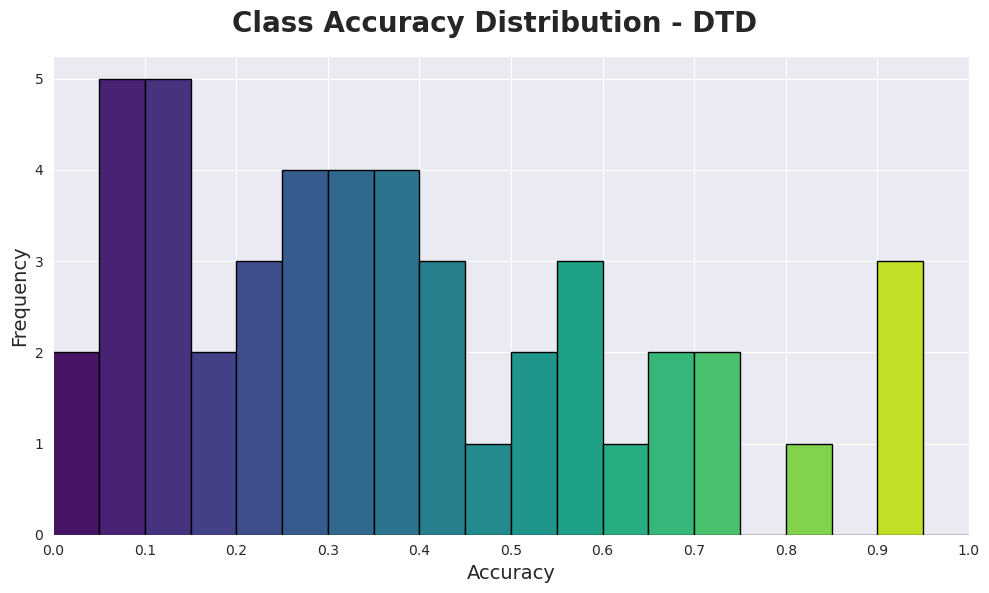

In [162]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=4)


Model is shown only 4 images per class from the dataset.

#### RESISC45

In [163]:
vit_resisc45_4 = Backbone(model_names['ViT'], num_classes=len(resisc45_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [164]:
get_model_params(vit_resisc45_4)

Parameters: 85.83M


In [165]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    vit_resisc45_4,
    resisc45_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 23/23 [00:01<00:00, 12.34it/s]


Epochs: 1/10 | train_loss: 4.0155 | train_acc: 0.0556


100%|██████████| 23/23 [00:01<00:00, 12.40it/s]


Epochs: 2/10 | train_loss: 2.1291 | train_acc: 0.6667


100%|██████████| 23/23 [00:01<00:00, 12.41it/s]


Epochs: 3/10 | train_loss: 1.2437 | train_acc: 0.8944


100%|██████████| 23/23 [00:01<00:00, 12.41it/s]


Epochs: 4/10 | train_loss: 0.7603 | train_acc: 0.9778


100%|██████████| 23/23 [00:01<00:00, 12.36it/s]


Epochs: 5/10 | train_loss: 0.5018 | train_acc: 0.9944


100%|██████████| 23/23 [00:01<00:00, 12.38it/s]


Epochs: 6/10 | train_loss: 0.3498 | train_acc: 1.0000


100%|██████████| 23/23 [00:01<00:00, 12.36it/s]


Epochs: 7/10 | train_loss: 0.2469 | train_acc: 1.0000


100%|██████████| 23/23 [00:01<00:00, 12.38it/s]


Epochs: 8/10 | train_loss: 0.1898 | train_acc: 1.0000


100%|██████████| 23/23 [00:01<00:00, 12.41it/s]


Epochs: 9/10 | train_loss: 0.1444 | train_acc: 1.0000


100%|██████████| 23/23 [00:01<00:00, 12.37it/s]

Epochs: 10/10 | train_loss: 0.1218 | train_acc: 1.0000


In [166]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    vit_resisc45_4,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:05<00:00, 12.10it/s]

test_loss: 1.7551 | test_acc: 0.5319


In [167]:
resisc45_accs.append(resisc45_acc)

In [169]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9801324503311258),
 ('beach', 0.8769230769230769),
 ('overpass', 0.8333333333333334),
 ('forest', 0.8082191780821918),
 ('cloud', 0.7987421383647799)]

In [170]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.17857142857142858),
 ('commercial area', 0.2),
 ('mobile home park', 0.20121951219512196),
 ('church', 0.2097902097902098),
 ('tennis court', 0.22916666666666666)]

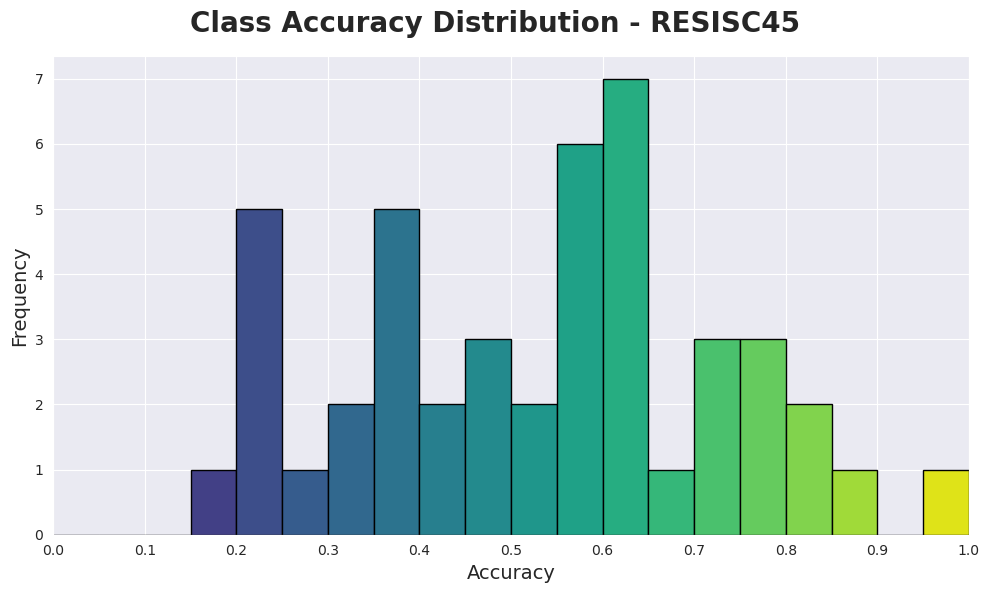

In [171]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [172]:
vit_food101_4 = Backbone(model_names['ViT'], num_classes=len(food101_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [173]:
get_model_params(vit_food101_4)

Parameters: 85.88M


In [174]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    vit_food101_4,
    food101_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 51/51 [00:04<00:00, 10.58it/s]


Epochs: 1/10 | train_loss: 4.6600 | train_acc: 0.1287


100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


Epochs: 2/10 | train_loss: 1.7346 | train_acc: 0.7797


100%|██████████| 51/51 [00:04<00:00, 10.60it/s]


Epochs: 3/10 | train_loss: 0.6434 | train_acc: 0.9752


100%|██████████| 51/51 [00:04<00:00, 10.66it/s]


Epochs: 4/10 | train_loss: 0.2769 | train_acc: 0.9975


100%|██████████| 51/51 [00:04<00:00, 10.66it/s]


Epochs: 5/10 | train_loss: 0.1500 | train_acc: 0.9975


100%|██████████| 51/51 [00:04<00:00, 10.60it/s]


Epochs: 6/10 | train_loss: 0.0978 | train_acc: 1.0000


100%|██████████| 51/51 [00:04<00:00, 10.57it/s]


Epochs: 7/10 | train_loss: 0.0723 | train_acc: 1.0000


100%|██████████| 51/51 [00:04<00:00, 10.50it/s]


Epochs: 8/10 | train_loss: 0.0571 | train_acc: 1.0000


100%|██████████| 51/51 [00:04<00:00, 10.62it/s]


Epochs: 9/10 | train_loss: 0.0456 | train_acc: 1.0000


100%|██████████| 51/51 [00:04<00:00, 10.57it/s]

Epochs: 10/10 | train_loss: 0.0381 | train_acc: 1.0000


In [175]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    vit_food101_4,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:00<00:00, 10.52it/s]


test_loss: 1.3619 | test_acc: 0.6550


In [176]:
food101_accs.append(food101_acc)

In [178]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.984),
 ('pizza', 0.972),
 ('oysters', 0.956),
 ('spaghetti carbonara', 0.952),
 ('guacamole', 0.936)]

In [179]:
get_bottom_5_accuracies(food101_per_class_acc)

[('cheesecake', 0.172),
 ('gnocchi', 0.176),
 ('ravioli', 0.224),
 ('tuna tartare', 0.232),
 ('grilled salmon', 0.26)]

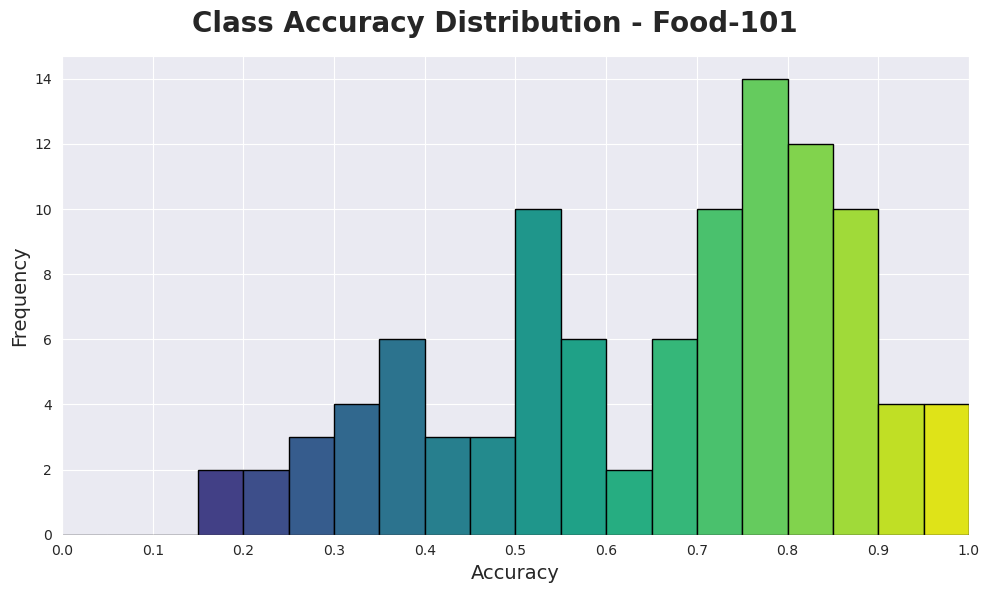

In [180]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [181]:
vit_fer2013_4 = Backbone(model_names['ViT'], num_classes=len(fer2013_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [182]:
get_model_params(vit_fer2013_4)

Parameters: 85.80M


In [183]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    vit_fer2013_4,
    fer2013_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 4/4 [00:00<00:00, 14.29it/s]


Epochs: 1/10 | train_loss: 2.1401 | train_acc: 0.0714


100%|██████████| 4/4 [00:00<00:00, 14.46it/s]


Epochs: 2/10 | train_loss: 1.5983 | train_acc: 0.4286


100%|██████████| 4/4 [00:00<00:00, 14.25it/s]


Epochs: 3/10 | train_loss: 1.3038 | train_acc: 0.4643


100%|██████████| 4/4 [00:00<00:00, 14.24it/s]


Epochs: 4/10 | train_loss: 1.1777 | train_acc: 0.6786


100%|██████████| 4/4 [00:00<00:00, 14.48it/s]


Epochs: 5/10 | train_loss: 0.9065 | train_acc: 0.8214


100%|██████████| 4/4 [00:00<00:00, 14.47it/s]


Epochs: 6/10 | train_loss: 0.7299 | train_acc: 0.8929


100%|██████████| 4/4 [00:00<00:00, 14.47it/s]


Epochs: 7/10 | train_loss: 0.6325 | train_acc: 0.9643


100%|██████████| 4/4 [00:00<00:00, 14.52it/s]


Epochs: 8/10 | train_loss: 0.5137 | train_acc: 0.9643


100%|██████████| 4/4 [00:00<00:00, 14.51it/s]


Epochs: 9/10 | train_loss: 0.4173 | train_acc: 1.0000


100%|██████████| 4/4 [00:00<00:00, 14.45it/s]

Epochs: 10/10 | train_loss: 0.3660 | train_acc: 1.0000


In [184]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    vit_fer2013_4,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:35<00:00, 12.77it/s]

test_loss: 1.7993 | test_acc: 0.3115


In [185]:
fer2013_accs.append(fer2013_acc)

In [187]:
fer2013_per_class_acc

{'angry': 0.20162932790224034,
 'disgust': 0.3090909090909091,
 'fear': 0.19886363636363635,
 'happy': 0.47554038680318544,
 'sad': 0.3383838383838384,
 'surprise': 0.3485576923076923,
 'neutral': 0.2124600638977636}

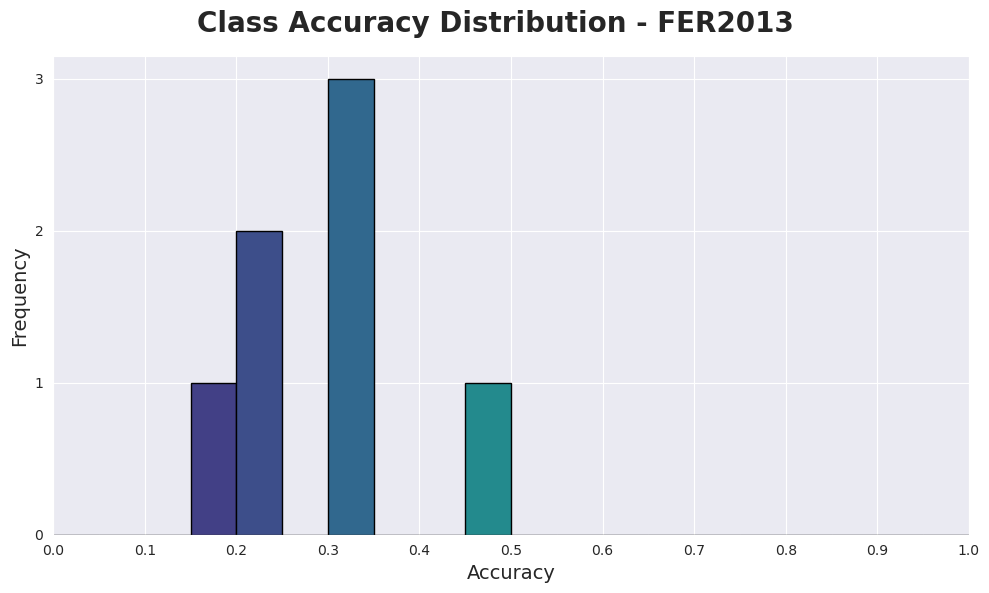

In [188]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [189]:
vit_pcam_4 = Backbone(model_names['ViT'], num_classes=len(pcam_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [190]:
get_model_params(vit_pcam_4)

Parameters: 85.80M


In [191]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    vit_pcam_4,
    pcam_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


Epochs: 1/10 | train_loss: 0.6534 | train_acc: 0.5000


100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


Epochs: 2/10 | train_loss: 0.5510 | train_acc: 0.8750


100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


Epochs: 3/10 | train_loss: 0.5125 | train_acc: 0.8750


100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


Epochs: 4/10 | train_loss: 0.4567 | train_acc: 0.8750


100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


Epochs: 5/10 | train_loss: 0.3982 | train_acc: 0.8750


100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


Epochs: 6/10 | train_loss: 0.3528 | train_acc: 0.8750


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Epochs: 7/10 | train_loss: 0.3211 | train_acc: 0.8750


100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


Epochs: 8/10 | train_loss: 0.2943 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


Epochs: 9/10 | train_loss: 0.2666 | train_acc: 1.0000


100%|██████████| 1/1 [00:00<00:00, 11.37it/s]

Epochs: 10/10 | train_loss: 0.2387 | train_acc: 1.0000


In [192]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    vit_pcam_4,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [05:21<00:00, 12.74it/s]

test_loss: 0.9358 | test_acc: 0.4687


In [193]:
pcam_accs.append(pcam_acc)

In [195]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.4891098773717284,
 'lymph node tumor tissue': 0.4482505953471332}

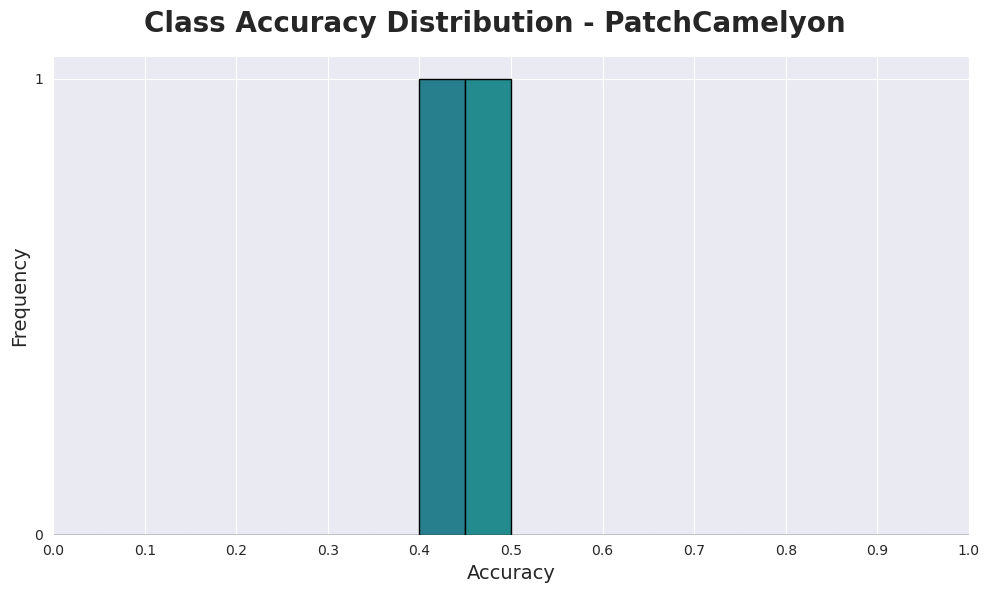

In [196]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [197]:
vit_sun397_4 = Backbone(model_names['ViT'], num_classes=len(sun397_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [198]:
get_model_params(vit_sun397_4)

Parameters: 86.10M


In [199]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    vit_sun397_4,
    sun397_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 199/199 [00:20<00:00,  9.67it/s]


Epochs: 1/10 | train_loss: 4.8900 | train_acc: 0.1996


100%|██████████| 199/199 [00:20<00:00,  9.91it/s]


Epochs: 2/10 | train_loss: 0.8110 | train_acc: 0.8615


100%|██████████| 199/199 [00:20<00:00,  9.91it/s]


Epochs: 3/10 | train_loss: 0.1814 | train_acc: 0.9817


100%|██████████| 199/199 [00:19<00:00,  9.96it/s]


Epochs: 4/10 | train_loss: 0.0808 | train_acc: 0.9943


100%|██████████| 199/199 [00:20<00:00,  9.91it/s]


Epochs: 5/10 | train_loss: 0.0459 | train_acc: 0.9962


100%|██████████| 199/199 [00:20<00:00,  9.93it/s]


Epochs: 6/10 | train_loss: 0.0299 | train_acc: 1.0000


100%|██████████| 199/199 [00:20<00:00,  9.93it/s]


Epochs: 7/10 | train_loss: 0.0226 | train_acc: 1.0000


100%|██████████| 199/199 [00:19<00:00,  9.95it/s]


Epochs: 8/10 | train_loss: 0.0177 | train_acc: 1.0000


100%|██████████| 199/199 [00:20<00:00,  9.94it/s]


Epochs: 9/10 | train_loss: 0.0144 | train_acc: 1.0000


100%|██████████| 199/199 [00:19<00:00,  9.96it/s]

Epochs: 10/10 | train_loss: 0.0121 | train_acc: 1.0000


In [200]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    vit_sun397_4,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [04:35<00:00,  9.86it/s]


test_loss: 1.4736 | test_acc: 0.6125


In [203]:
sun397_accs.append(sun397_acc)

In [207]:
get_top_5_accuracies(sun397_per_class_acc)

[('bullring', 1.0),
 ('greenhouse (outdoor)', 1.0),
 ('nursery', 1.0),
 ('oast house', 1.0),
 ('raceway', 1.0)]

In [208]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('building facade', 0.06944444444444445),
 ('nuclear power plant (outdoor)', 0.09090909090909091),
 ('library (outdoor)', 0.09523809523809523),
 ('museum (indoor)', 0.10526315789473684),
 ('monastery (outdoor)', 0.13793103448275862)]

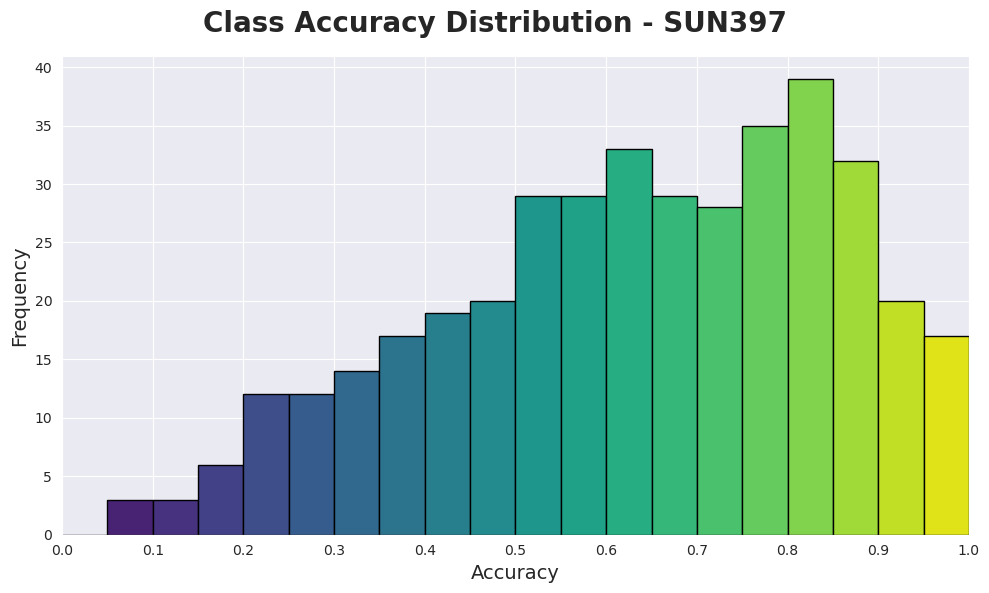

In [209]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [210]:
vit_dtd_4 = Backbone(model_names['ViT'], num_classes=len(dtd_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [211]:
get_model_params(vit_dtd_4)

Parameters: 85.83M


In [212]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    vit_dtd_4,
    dtd_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=4
)

100%|██████████| 24/24 [00:02<00:00,  9.67it/s]


Epochs: 1/10 | train_loss: 3.8736 | train_acc: 0.0638


100%|██████████| 24/24 [00:02<00:00,  9.85it/s]


Epochs: 2/10 | train_loss: 1.9075 | train_acc: 0.7926


100%|██████████| 24/24 [00:02<00:00,  9.82it/s]


Epochs: 3/10 | train_loss: 0.8555 | train_acc: 0.9681


100%|██████████| 24/24 [00:02<00:00,  9.87it/s]


Epochs: 4/10 | train_loss: 0.3956 | train_acc: 0.9947


100%|██████████| 24/24 [00:02<00:00,  9.82it/s]


Epochs: 5/10 | train_loss: 0.2105 | train_acc: 0.9947


100%|██████████| 24/24 [00:02<00:00,  9.86it/s]


Epochs: 6/10 | train_loss: 0.1385 | train_acc: 1.0000


100%|██████████| 24/24 [00:02<00:00,  9.72it/s]


Epochs: 7/10 | train_loss: 0.0989 | train_acc: 1.0000


100%|██████████| 24/24 [00:02<00:00,  9.78it/s]


Epochs: 8/10 | train_loss: 0.0774 | train_acc: 1.0000


100%|██████████| 24/24 [00:02<00:00,  9.77it/s]


Epochs: 9/10 | train_loss: 0.0626 | train_acc: 1.0000


100%|██████████| 24/24 [00:02<00:00,  9.81it/s]

Epochs: 10/10 | train_loss: 0.0525 | train_acc: 1.0000


In [213]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    vit_dtd_4,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:22<00:00, 10.25it/s]

test_loss: 2.1832 | test_acc: 0.4569


In [214]:
dtd_accs.append(dtd_acc)

In [216]:
get_top_5_accuracies(dtd_per_class_acc)

[('cobwebbed', 0.925),
 ('knitted', 0.925),
 ('potholed', 0.925),
 ('studded', 0.875),
 ('frilly', 0.85)]

In [217]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('blotchy', 0.1),
 ('flecked', 0.1),
 ('pitted', 0.1),
 ('woven', 0.125),
 ('braided', 0.175)]

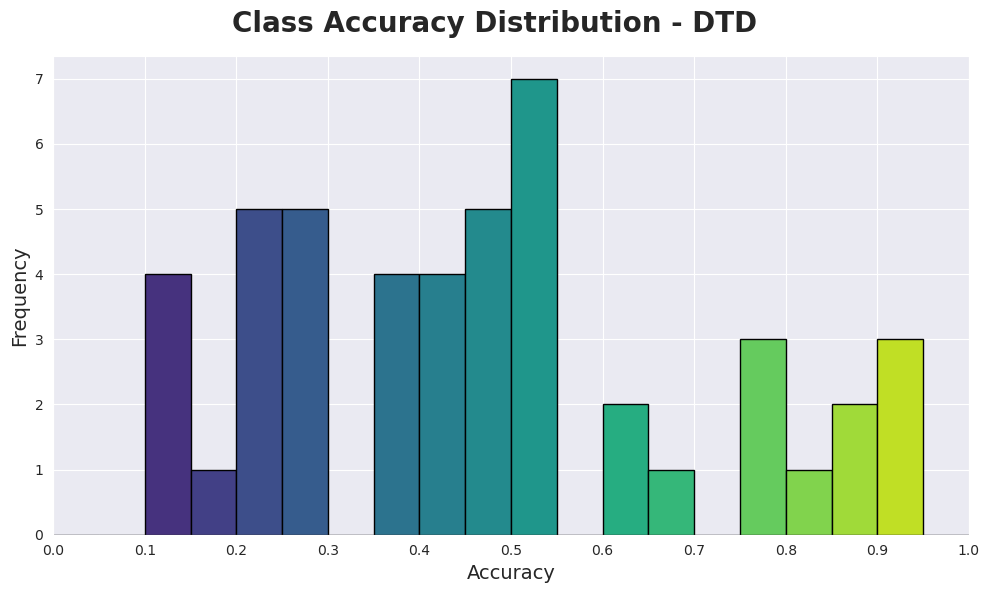

In [218]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=8)


Model is shown only 8 images per class from the dataset.

#### RESISC45

In [219]:
vit_resisc45_8 = Backbone(model_names['ViT'], num_classes=len(resisc45_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [220]:
get_model_params(vit_resisc45_8)

Parameters: 85.83M


In [221]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    vit_resisc45_8,
    resisc45_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 45/45 [00:03<00:00, 12.08it/s]


Epochs: 1/10 | train_loss: 3.4519 | train_acc: 0.1750


100%|██████████| 45/45 [00:03<00:00, 12.13it/s]


Epochs: 2/10 | train_loss: 1.6508 | train_acc: 0.6500


100%|██████████| 45/45 [00:03<00:00, 12.11it/s]


Epochs: 3/10 | train_loss: 0.9840 | train_acc: 0.8444


100%|██████████| 45/45 [00:03<00:00, 12.15it/s]


Epochs: 4/10 | train_loss: 0.6429 | train_acc: 0.9333


100%|██████████| 45/45 [00:03<00:00, 12.08it/s]


Epochs: 5/10 | train_loss: 0.4496 | train_acc: 0.9750


100%|██████████| 45/45 [00:03<00:00, 12.11it/s]


Epochs: 6/10 | train_loss: 0.3191 | train_acc: 0.9917


100%|██████████| 45/45 [00:03<00:00, 12.12it/s]


Epochs: 7/10 | train_loss: 0.2362 | train_acc: 0.9917


100%|██████████| 45/45 [00:03<00:00, 12.12it/s]


Epochs: 8/10 | train_loss: 0.1865 | train_acc: 1.0000


100%|██████████| 45/45 [00:03<00:00, 12.13it/s]


Epochs: 9/10 | train_loss: 0.1447 | train_acc: 1.0000


100%|██████████| 45/45 [00:03<00:00, 12.09it/s]

Epochs: 10/10 | train_loss: 0.1171 | train_acc: 1.0000


In [222]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    vit_resisc45_8,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:05<00:00, 12.08it/s]

test_loss: 1.3643 | test_acc: 0.6162


In [223]:
resisc45_accs.append(resisc45_acc)

In [225]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9735099337748344),
 ('beach', 0.8461538461538461),
 ('snowberg', 0.8301886792452831),
 ('mountain', 0.8173913043478261),
 ('harbor', 0.8028169014084507)]

In [226]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('church', 0.08391608391608392),
 ('tennis court', 0.2708333333333333),
 ('basketball court', 0.2835820895522388),
 ('palace', 0.3),
 ('baseball diamond', 0.34959349593495936)]

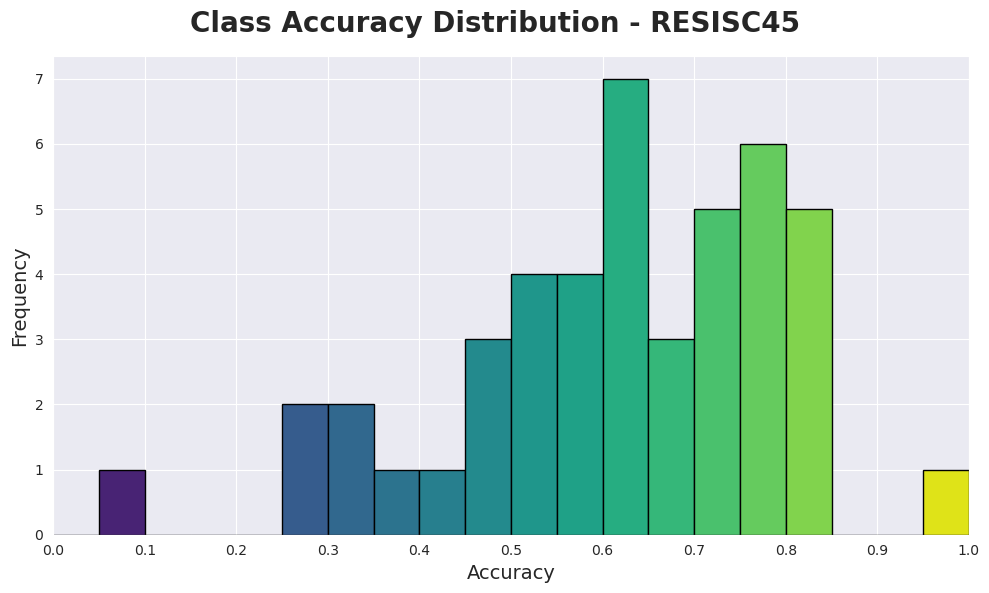

In [227]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [228]:
vit_food101_8 = Backbone(model_names['ViT'], num_classes=len(food101_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [229]:
get_model_params(vit_food101_8)

Parameters: 85.88M


In [230]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    vit_food101_8,
    food101_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 101/101 [00:09<00:00, 10.51it/s]


Epochs: 1/10 | train_loss: 3.6472 | train_acc: 0.2822


100%|██████████| 101/101 [00:09<00:00, 10.43it/s]


Epochs: 2/10 | train_loss: 1.0880 | train_acc: 0.8230


100%|██████████| 101/101 [00:09<00:00, 10.57it/s]


Epochs: 3/10 | train_loss: 0.4606 | train_acc: 0.9406


100%|██████████| 101/101 [00:09<00:00, 10.51it/s]


Epochs: 4/10 | train_loss: 0.2297 | train_acc: 0.9938


100%|██████████| 101/101 [00:09<00:00, 10.53it/s]


Epochs: 5/10 | train_loss: 0.1277 | train_acc: 0.9963


100%|██████████| 101/101 [00:09<00:00, 10.47it/s]


Epochs: 6/10 | train_loss: 0.0855 | train_acc: 0.9988


100%|██████████| 101/101 [00:09<00:00, 10.53it/s]


Epochs: 7/10 | train_loss: 0.0612 | train_acc: 1.0000


100%|██████████| 101/101 [00:09<00:00, 10.38it/s]


Epochs: 8/10 | train_loss: 0.0473 | train_acc: 1.0000


100%|██████████| 101/101 [00:09<00:00, 10.49it/s]


Epochs: 9/10 | train_loss: 0.0379 | train_acc: 1.0000


100%|██████████| 101/101 [00:09<00:00, 10.43it/s]

Epochs: 10/10 | train_loss: 0.0313 | train_acc: 1.0000


In [231]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    vit_food101_8,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:01<00:00, 10.48it/s]


test_loss: 1.0526 | test_acc: 0.7171


In [232]:
food101_accs.append(food101_acc)

In [234]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.976),
 ('pizza', 0.964),
 ('oysters', 0.956),
 ('spaghetti carbonara', 0.94),
 ('guacamole', 0.924)]

In [235]:
get_bottom_5_accuracies(food101_per_class_acc)

[('ravioli', 0.148),
 ('scallops', 0.3),
 ('chocolate cake', 0.364),
 ('grilled salmon', 0.384),
 ('bread pudding', 0.388)]

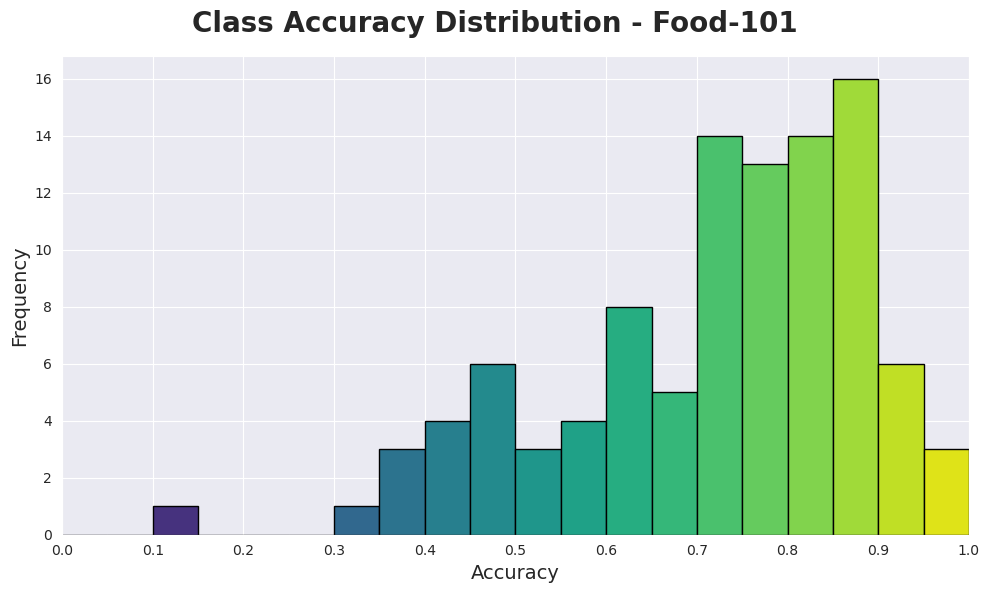

In [236]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [237]:
vit_fer2013_8 = Backbone(model_names['ViT'], num_classes=len(fer2013_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [238]:
get_model_params(vit_fer2013_8)

Parameters: 85.80M


In [239]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    vit_fer2013_8,
    fer2013_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 7/7 [00:00<00:00, 12.74it/s]


Epochs: 1/10 | train_loss: 2.1143 | train_acc: 0.1607


100%|██████████| 7/7 [00:00<00:00, 12.93it/s]


Epochs: 2/10 | train_loss: 1.5867 | train_acc: 0.4464


100%|██████████| 7/7 [00:00<00:00, 12.94it/s]


Epochs: 3/10 | train_loss: 1.3063 | train_acc: 0.6607


100%|██████████| 7/7 [00:00<00:00, 12.94it/s]


Epochs: 4/10 | train_loss: 1.0852 | train_acc: 0.7500


100%|██████████| 7/7 [00:00<00:00, 12.94it/s]


Epochs: 5/10 | train_loss: 0.9136 | train_acc: 0.8393


100%|██████████| 7/7 [00:00<00:00, 12.96it/s]


Epochs: 6/10 | train_loss: 0.7907 | train_acc: 0.8929


100%|██████████| 7/7 [00:00<00:00, 12.93it/s]


Epochs: 7/10 | train_loss: 0.6815 | train_acc: 0.9643


100%|██████████| 7/7 [00:00<00:00, 12.93it/s]


Epochs: 8/10 | train_loss: 0.5965 | train_acc: 0.9286


100%|██████████| 7/7 [00:00<00:00, 12.89it/s]


Epochs: 9/10 | train_loss: 0.5158 | train_acc: 0.9286


100%|██████████| 7/7 [00:00<00:00, 12.95it/s]

Epochs: 10/10 | train_loss: 0.4620 | train_acc: 0.9643


In [240]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    vit_fer2013_8,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:34<00:00, 12.88it/s]

test_loss: 1.8798 | test_acc: 0.3096


In [241]:
fer2013_accs.append(fer2013_acc)

In [243]:
fer2013_per_class_acc

{'angry': 0.2668024439918534,
 'disgust': 0.38181818181818183,
 'fear': 0.2537878787878788,
 'happy': 0.3720136518771331,
 'sad': 0.41919191919191917,
 'surprise': 0.2644230769230769,
 'neutral': 0.2220447284345048}

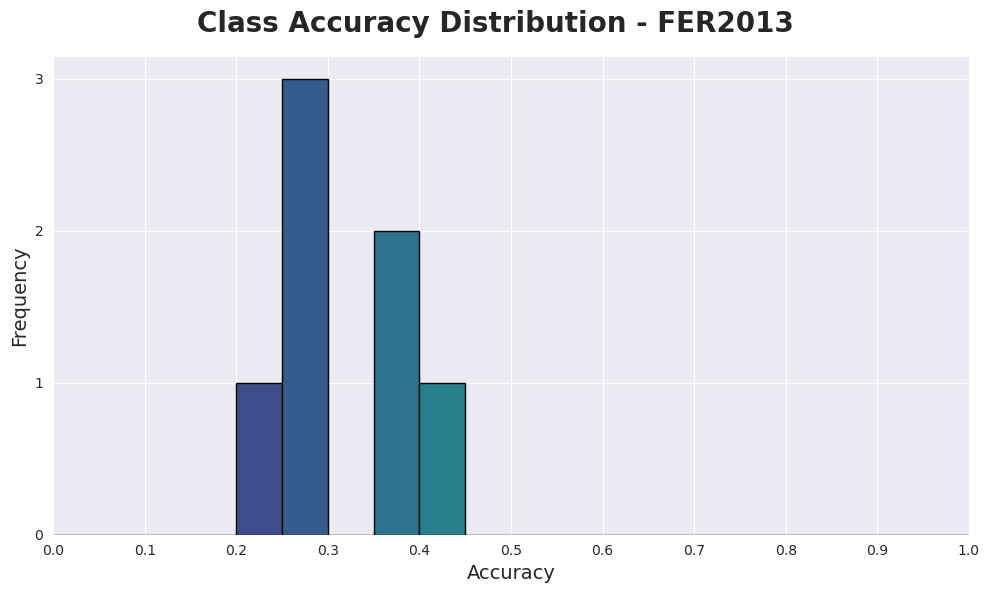

In [244]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [245]:
vit_pcam_8 = Backbone(model_names['ViT'], num_classes=len(pcam_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [246]:
get_model_params(vit_pcam_8)

Parameters: 85.80M


In [247]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    vit_pcam_8,
    pcam_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 2/2 [00:00<00:00, 12.30it/s]


Epochs: 1/10 | train_loss: 0.7453 | train_acc: 0.6250


100%|██████████| 2/2 [00:00<00:00, 12.58it/s]


Epochs: 2/10 | train_loss: 0.6567 | train_acc: 0.5625


100%|██████████| 2/2 [00:00<00:00, 12.68it/s]


Epochs: 3/10 | train_loss: 0.6132 | train_acc: 0.7500


100%|██████████| 2/2 [00:00<00:00, 12.73it/s]


Epochs: 4/10 | train_loss: 0.5265 | train_acc: 0.6875


100%|██████████| 2/2 [00:00<00:00, 12.71it/s]


Epochs: 5/10 | train_loss: 0.4980 | train_acc: 0.6875


100%|██████████| 2/2 [00:00<00:00, 12.72it/s]


Epochs: 6/10 | train_loss: 0.4629 | train_acc: 0.7500


100%|██████████| 2/2 [00:00<00:00, 12.74it/s]


Epochs: 7/10 | train_loss: 0.4445 | train_acc: 0.8125


100%|██████████| 2/2 [00:00<00:00, 12.49it/s]


Epochs: 8/10 | train_loss: 0.4107 | train_acc: 0.8750


100%|██████████| 2/2 [00:00<00:00, 12.73it/s]


Epochs: 9/10 | train_loss: 0.3820 | train_acc: 0.8750


100%|██████████| 2/2 [00:00<00:00, 12.72it/s]

Epochs: 10/10 | train_loss: 0.3516 | train_acc: 0.8750


In [248]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    vit_pcam_8,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [05:21<00:00, 12.73it/s]

test_loss: 0.5604 | test_acc: 0.7201


In [249]:
pcam_accs.append(pcam_acc)

In [251]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.6671954121164053,
 'lymph node tumor tissue': 0.773096415704952}

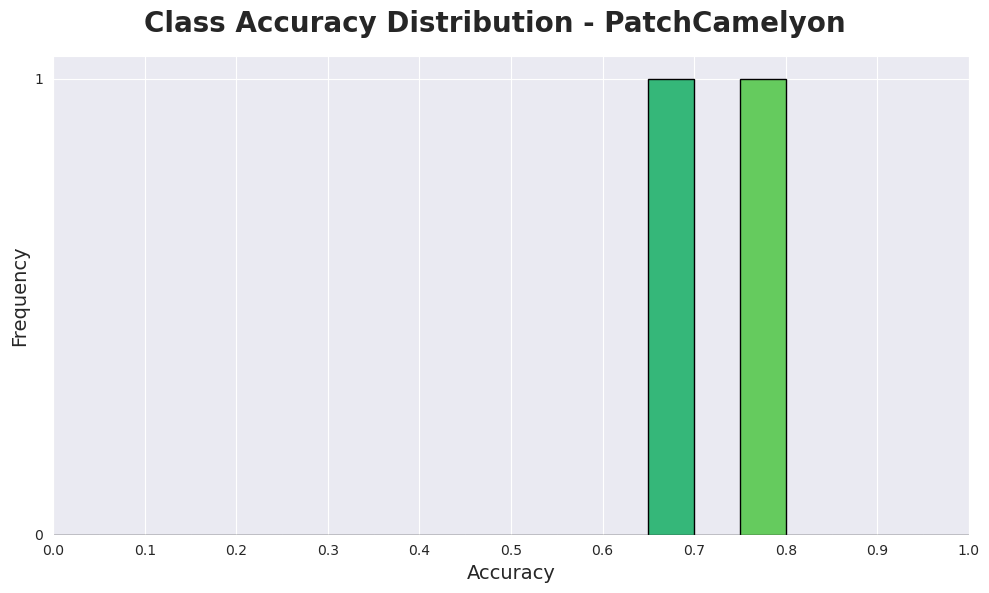

In [252]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [253]:
vit_sun397_8 = Backbone(model_names['ViT'], num_classes=len(sun397_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [254]:
get_model_params(vit_sun397_8)

Parameters: 86.10M


In [255]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    vit_sun397_8,
    sun397_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 397/397 [00:40<00:00,  9.73it/s]


Epochs: 1/10 | train_loss: 3.4542 | train_acc: 0.3674


100%|██████████| 397/397 [00:40<00:00,  9.89it/s]


Epochs: 2/10 | train_loss: 0.5672 | train_acc: 0.8577


100%|██████████| 397/397 [00:40<00:00,  9.88it/s]


Epochs: 3/10 | train_loss: 0.1694 | train_acc: 0.9688


100%|██████████| 397/397 [00:40<00:00,  9.88it/s]


Epochs: 4/10 | train_loss: 0.0776 | train_acc: 0.9890


100%|██████████| 397/397 [00:40<00:00,  9.91it/s]


Epochs: 5/10 | train_loss: 0.0417 | train_acc: 0.9953


100%|██████████| 397/397 [00:40<00:00,  9.90it/s]


Epochs: 6/10 | train_loss: 0.0247 | train_acc: 0.9994


100%|██████████| 397/397 [00:40<00:00,  9.91it/s]


Epochs: 7/10 | train_loss: 0.0177 | train_acc: 0.9997


100%|██████████| 397/397 [00:40<00:00,  9.90it/s]


Epochs: 8/10 | train_loss: 0.0126 | train_acc: 1.0000


100%|██████████| 397/397 [00:40<00:00,  9.87it/s]


Epochs: 9/10 | train_loss: 0.0110 | train_acc: 0.9991


100%|██████████| 397/397 [00:40<00:00,  9.90it/s]

Epochs: 10/10 | train_loss: 0.0081 | train_acc: 1.0000


In [256]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    vit_sun397_8,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [04:36<00:00,  9.83it/s]


test_loss: 1.3063 | test_acc: 0.6598


In [257]:
sun397_accs.append(sun397_acc)

In [259]:
get_top_5_accuracies(sun397_per_class_acc)

[('bullring', 1.0),
 ('greenhouse (outdoor)', 1.0),
 ('nursery', 1.0),
 ('oast house', 1.0),
 ('raceway', 1.0)]

In [260]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('recreation room', 0.1111111111111111),
 ('library (outdoor)', 0.14285714285714285),
 ('museum (indoor)', 0.19298245614035087),
 ('building facade', 0.2361111111111111),
 ('office building', 0.24561403508771928)]

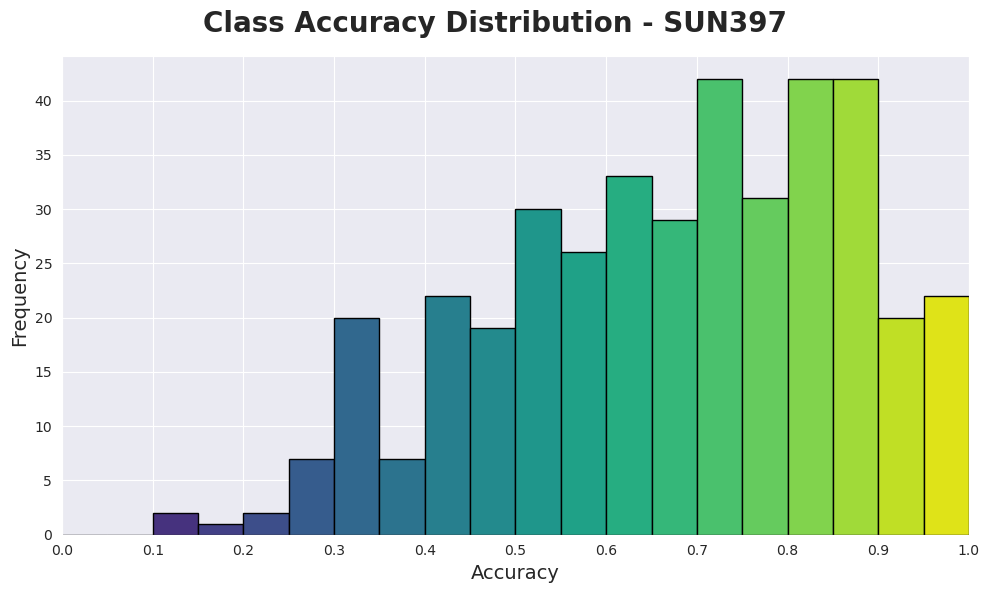

In [261]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [262]:
vit_dtd_8 = Backbone(model_names['ViT'], num_classes=len(dtd_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [263]:
get_model_params(vit_dtd_8)

Parameters: 85.83M


In [264]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    vit_dtd_8,
    dtd_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=8
)

100%|██████████| 47/47 [00:04<00:00,  9.62it/s]


Epochs: 1/10 | train_loss: 3.3665 | train_acc: 0.2074


100%|██████████| 47/47 [00:04<00:00,  9.65it/s]


Epochs: 2/10 | train_loss: 1.3530 | train_acc: 0.8324


100%|██████████| 47/47 [00:04<00:00,  9.69it/s]


Epochs: 3/10 | train_loss: 0.6080 | train_acc: 0.9468


100%|██████████| 47/47 [00:04<00:00,  9.69it/s]


Epochs: 4/10 | train_loss: 0.3022 | train_acc: 0.9947


100%|██████████| 47/47 [00:04<00:00,  9.75it/s]


Epochs: 5/10 | train_loss: 0.1753 | train_acc: 0.9973


100%|██████████| 47/47 [00:04<00:00,  9.65it/s]


Epochs: 6/10 | train_loss: 0.1178 | train_acc: 1.0000


100%|██████████| 47/47 [00:04<00:00,  9.70it/s]


Epochs: 7/10 | train_loss: 0.0872 | train_acc: 1.0000


100%|██████████| 47/47 [00:04<00:00,  9.67it/s]


Epochs: 8/10 | train_loss: 0.0679 | train_acc: 1.0000


100%|██████████| 47/47 [00:04<00:00,  9.67it/s]


Epochs: 9/10 | train_loss: 0.0552 | train_acc: 1.0000


100%|██████████| 47/47 [00:04<00:00,  9.63it/s]

Epochs: 10/10 | train_loss: 0.0453 | train_acc: 1.0000


In [265]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    vit_dtd_8,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:22<00:00, 10.25it/s]

test_loss: 1.8201 | test_acc: 0.5218


In [266]:
dtd_accs.append(dtd_acc)

In [268]:
get_top_5_accuracies(dtd_per_class_acc)

[('potholed', 0.95),
 ('cobwebbed', 0.875),
 ('studded', 0.85),
 ('waffled', 0.85),
 ('crystalline', 0.825)]

In [269]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('flecked', 0.1),
 ('pitted', 0.175),
 ('porous', 0.175),
 ('swirly', 0.175),
 ('blotchy', 0.2)]

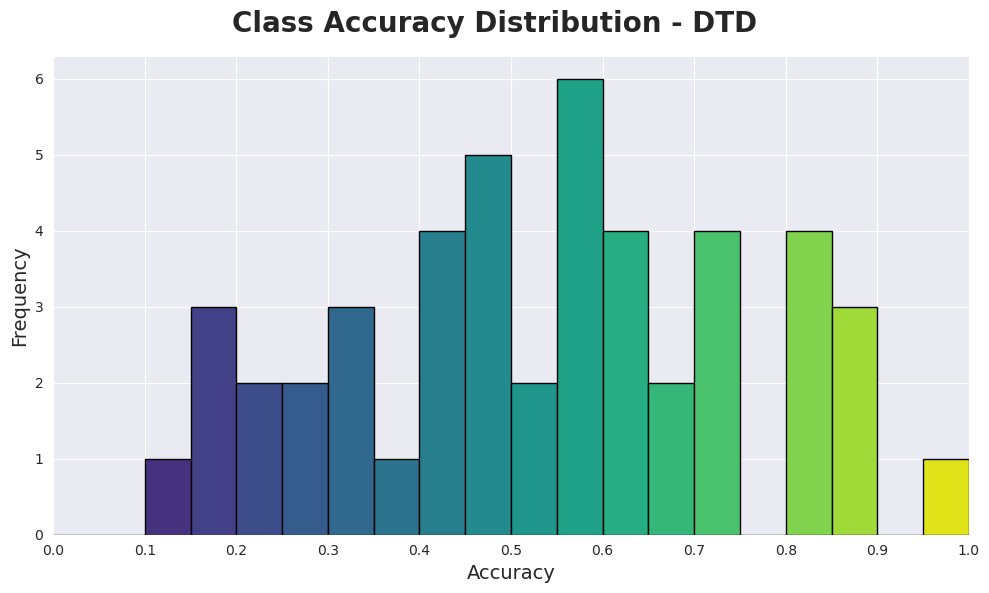

In [270]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Few-Shot Linear Probing (n=16)


Model is shown only 16 images per class from the dataset.

#### RESISC45

In [271]:
vit_resisc45_16 = Backbone(model_names['ViT'], num_classes=len(resisc45_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [272]:
get_model_params(vit_resisc45_16)

Parameters: 85.83M


In [273]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    vit_resisc45_16,
    resisc45_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 90/90 [00:07<00:00, 12.12it/s]


Epochs: 1/10 | train_loss: 2.8776 | train_acc: 0.3167


100%|██████████| 90/90 [00:07<00:00, 12.13it/s]


Epochs: 2/10 | train_loss: 1.2253 | train_acc: 0.7153


100%|██████████| 90/90 [00:07<00:00, 12.13it/s]


Epochs: 3/10 | train_loss: 0.7672 | train_acc: 0.8333


100%|██████████| 90/90 [00:07<00:00, 12.12it/s]


Epochs: 4/10 | train_loss: 0.5107 | train_acc: 0.9097


100%|██████████| 90/90 [00:07<00:00, 12.08it/s]


Epochs: 5/10 | train_loss: 0.3711 | train_acc: 0.9556


100%|██████████| 90/90 [00:07<00:00, 11.88it/s]


Epochs: 6/10 | train_loss: 0.2639 | train_acc: 0.9792


100%|██████████| 90/90 [00:07<00:00, 12.11it/s]


Epochs: 7/10 | train_loss: 0.2074 | train_acc: 0.9875


100%|██████████| 90/90 [00:07<00:00, 12.13it/s]


Epochs: 8/10 | train_loss: 0.1598 | train_acc: 0.9903


100%|██████████| 90/90 [00:07<00:00, 12.16it/s]


Epochs: 9/10 | train_loss: 0.1286 | train_acc: 0.9958


100%|██████████| 90/90 [00:07<00:00, 12.14it/s]

Epochs: 10/10 | train_loss: 0.1027 | train_acc: 1.0000


In [274]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    vit_resisc45_16,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:05<00:00, 12.12it/s]

test_loss: 1.0676 | test_acc: 0.6917


In [275]:
resisc45_accs.append(resisc45_acc)

In [277]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9668874172185431),
 ('beach', 0.9076923076923077),
 ('snowberg', 0.8930817610062893),
 ('cloud', 0.8301886792452831),
 ('golf course', 0.8278688524590164)]

In [278]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('basketball court', 0.417910447761194),
 ('tennis court', 0.4236111111111111),
 ('palace', 0.44285714285714284),
 ('railway station', 0.4805194805194805),
 ('medium residential', 0.5034013605442177)]

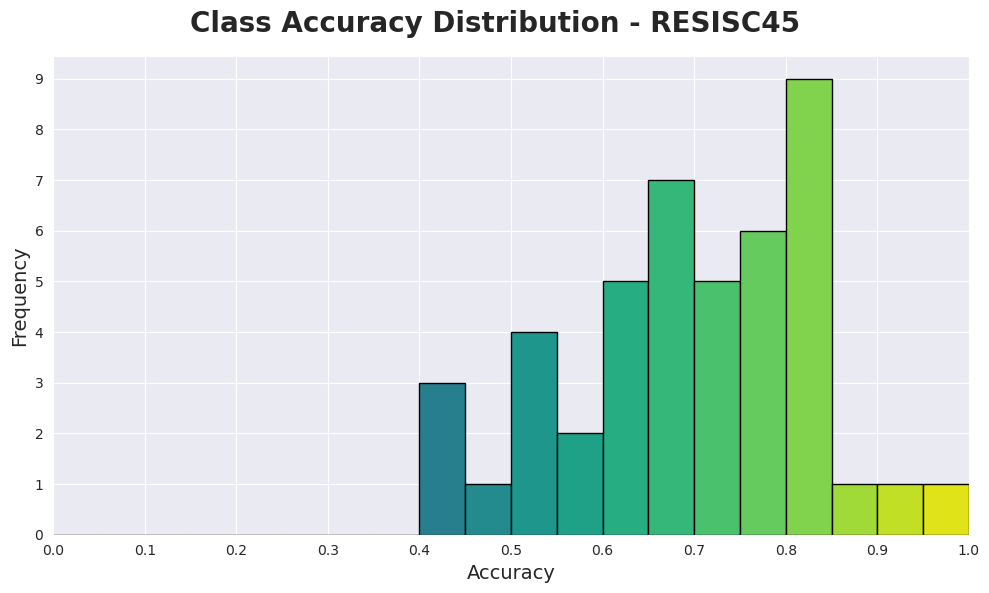

In [279]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [280]:
vit_food101_16 = Backbone(model_names['ViT'], num_classes=len(food101_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [281]:
get_model_params(vit_food101_16)

Parameters: 85.88M


In [282]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    vit_food101_16,
    food101_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 202/202 [00:19<00:00, 10.43it/s]


Epochs: 1/10 | train_loss: 2.7090 | train_acc: 0.4282


100%|██████████| 202/202 [00:19<00:00, 10.49it/s]


Epochs: 2/10 | train_loss: 0.8158 | train_acc: 0.8261


100%|██████████| 202/202 [00:19<00:00, 10.47it/s]


Epochs: 3/10 | train_loss: 0.3968 | train_acc: 0.9344


100%|██████████| 202/202 [00:19<00:00, 10.46it/s]


Epochs: 4/10 | train_loss: 0.2088 | train_acc: 0.9821


100%|██████████| 202/202 [00:19<00:00, 10.47it/s]


Epochs: 5/10 | train_loss: 0.1193 | train_acc: 0.9963


100%|██████████| 202/202 [00:19<00:00, 10.46it/s]


Epochs: 6/10 | train_loss: 0.0744 | train_acc: 1.0000


100%|██████████| 202/202 [00:19<00:00, 10.49it/s]


Epochs: 7/10 | train_loss: 0.0542 | train_acc: 1.0000


100%|██████████| 202/202 [00:19<00:00, 10.57it/s]


Epochs: 8/10 | train_loss: 0.0405 | train_acc: 1.0000


100%|██████████| 202/202 [00:19<00:00, 10.55it/s]


Epochs: 9/10 | train_loss: 0.0322 | train_acc: 1.0000


100%|██████████| 202/202 [00:19<00:00, 10.60it/s]

Epochs: 10/10 | train_loss: 0.0260 | train_acc: 1.0000


In [283]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    vit_food101_16,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [04:55<00:00, 10.68it/s]


test_loss: 0.8881 | test_acc: 0.7566


In [284]:
food101_accs.append(food101_acc)

In [286]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.984),
 ('spaghetti carbonara', 0.964),
 ('pizza', 0.96),
 ('hot and sour soup', 0.952),
 ('oysters', 0.944)]

In [287]:
get_bottom_5_accuracies(food101_per_class_acc)

[('ravioli', 0.344),
 ('foie gras', 0.372),
 ('pork chop', 0.416),
 ('scallops', 0.42),
 ('tuna tartare', 0.448)]

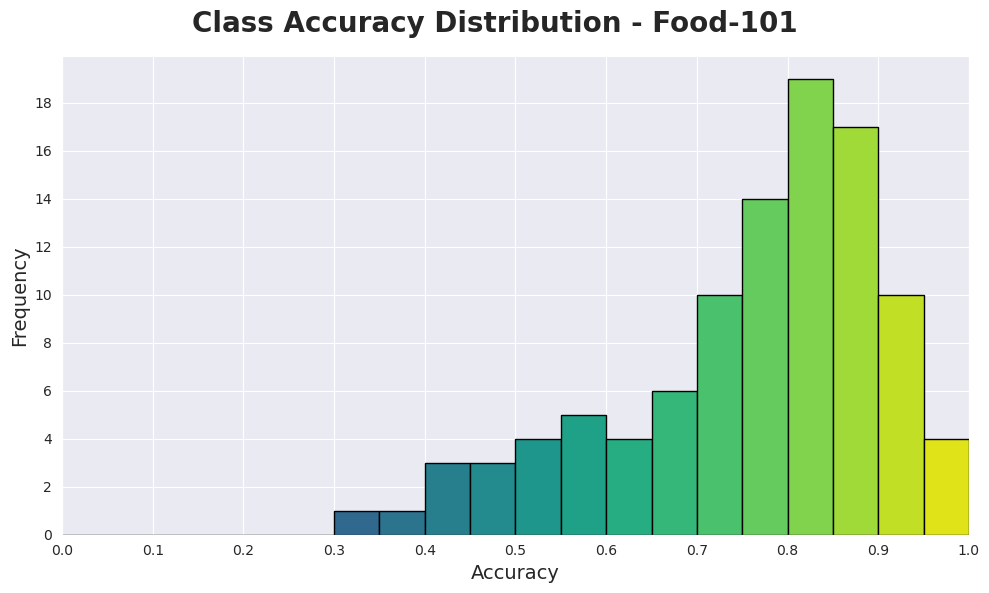

In [288]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [289]:
vit_fer2013_16 = Backbone(model_names['ViT'], num_classes=len(fer2013_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [290]:
get_model_params(vit_fer2013_16)

Parameters: 85.80M


In [291]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    vit_fer2013_16,
    fer2013_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 14/14 [00:01<00:00, 12.87it/s]


Epochs: 1/10 | train_loss: 1.9772 | train_acc: 0.2054


100%|██████████| 14/14 [00:01<00:00, 12.83it/s]


Epochs: 2/10 | train_loss: 1.4757 | train_acc: 0.5179


100%|██████████| 14/14 [00:01<00:00, 12.90it/s]


Epochs: 3/10 | train_loss: 1.2277 | train_acc: 0.5893


100%|██████████| 14/14 [00:01<00:00, 12.93it/s]


Epochs: 4/10 | train_loss: 1.0948 | train_acc: 0.6607


100%|██████████| 14/14 [00:01<00:00, 12.89it/s]


Epochs: 5/10 | train_loss: 0.9485 | train_acc: 0.6607


100%|██████████| 14/14 [00:01<00:00, 12.93it/s]


Epochs: 6/10 | train_loss: 0.8112 | train_acc: 0.8214


100%|██████████| 14/14 [00:01<00:00, 12.93it/s]


Epochs: 7/10 | train_loss: 0.7108 | train_acc: 0.8571


100%|██████████| 14/14 [00:01<00:00, 12.92it/s]


Epochs: 8/10 | train_loss: 0.6477 | train_acc: 0.8482


100%|██████████| 14/14 [00:01<00:00, 12.93it/s]


Epochs: 9/10 | train_loss: 0.5691 | train_acc: 0.9286


100%|██████████| 14/14 [00:01<00:00, 12.88it/s]

Epochs: 10/10 | train_loss: 0.5185 | train_acc: 0.9196


In [292]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    vit_fer2013_16,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:34<00:00, 12.86it/s]

test_loss: 1.6536 | test_acc: 0.4196


In [293]:
fer2013_accs.append(fer2013_acc)

In [295]:
fer2013_per_class_acc

{'angry': 0.4786150712830957,
 'disgust': 0.4,
 'fear': 0.18181818181818182,
 'happy': 0.6302616609783845,
 'sad': 0.30808080808080807,
 'surprise': 0.5168269230769231,
 'neutral': 0.3210862619808307}

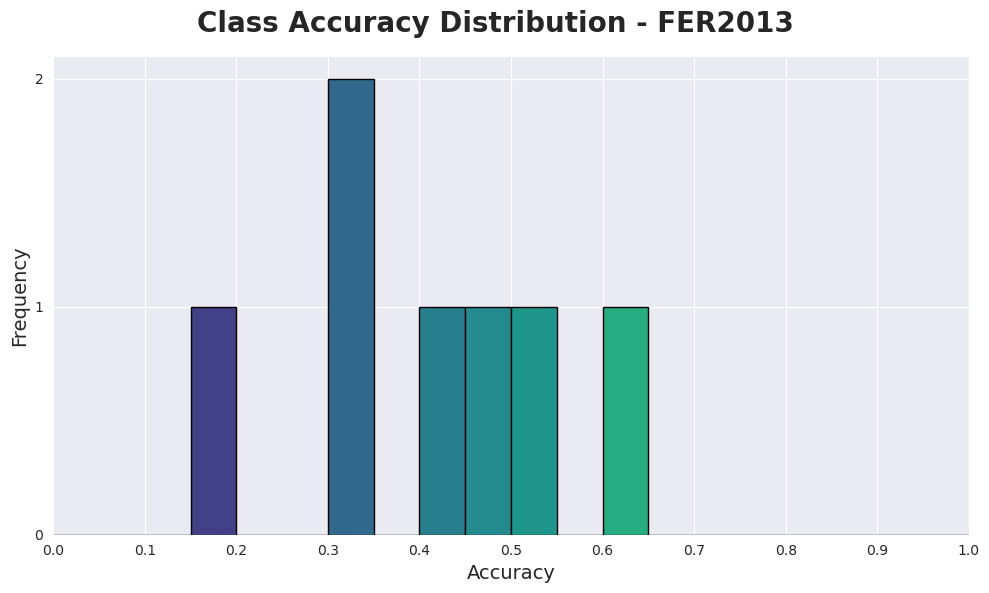

In [296]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [297]:
vit_pcam_16 = Backbone(model_names['ViT'], num_classes=len(pcam_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [298]:
get_model_params(vit_pcam_16)

Parameters: 85.80M


In [299]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    vit_pcam_16,
    pcam_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 4/4 [00:00<00:00, 12.58it/s]


Epochs: 1/10 | train_loss: 0.7790 | train_acc: 0.4062


100%|██████████| 4/4 [00:00<00:00, 12.78it/s]


Epochs: 2/10 | train_loss: 0.6075 | train_acc: 0.5938


100%|██████████| 4/4 [00:00<00:00, 12.80it/s]


Epochs: 3/10 | train_loss: 0.5330 | train_acc: 0.8125


100%|██████████| 4/4 [00:00<00:00, 12.81it/s]


Epochs: 4/10 | train_loss: 0.4570 | train_acc: 0.7812


100%|██████████| 4/4 [00:00<00:00, 12.76it/s]


Epochs: 5/10 | train_loss: 0.4227 | train_acc: 0.7812


100%|██████████| 4/4 [00:00<00:00, 12.83it/s]


Epochs: 6/10 | train_loss: 0.4021 | train_acc: 0.7812


100%|██████████| 4/4 [00:00<00:00, 12.82it/s]


Epochs: 7/10 | train_loss: 0.3638 | train_acc: 0.8125


100%|██████████| 4/4 [00:00<00:00, 12.79it/s]


Epochs: 8/10 | train_loss: 0.3496 | train_acc: 0.7812


100%|██████████| 4/4 [00:00<00:00, 12.81it/s]


Epochs: 9/10 | train_loss: 0.3230 | train_acc: 0.8125


100%|██████████| 4/4 [00:00<00:00, 12.80it/s]

Epochs: 10/10 | train_loss: 0.3056 | train_acc: 0.8438


In [300]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    vit_pcam_16,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [05:18<00:00, 12.85it/s]

test_loss: 0.5442 | test_acc: 0.7180


In [301]:
pcam_accs.append(pcam_acc)

In [303]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.7799402110914526,
 'lymph node tumor tissue': 0.6559809488917384}

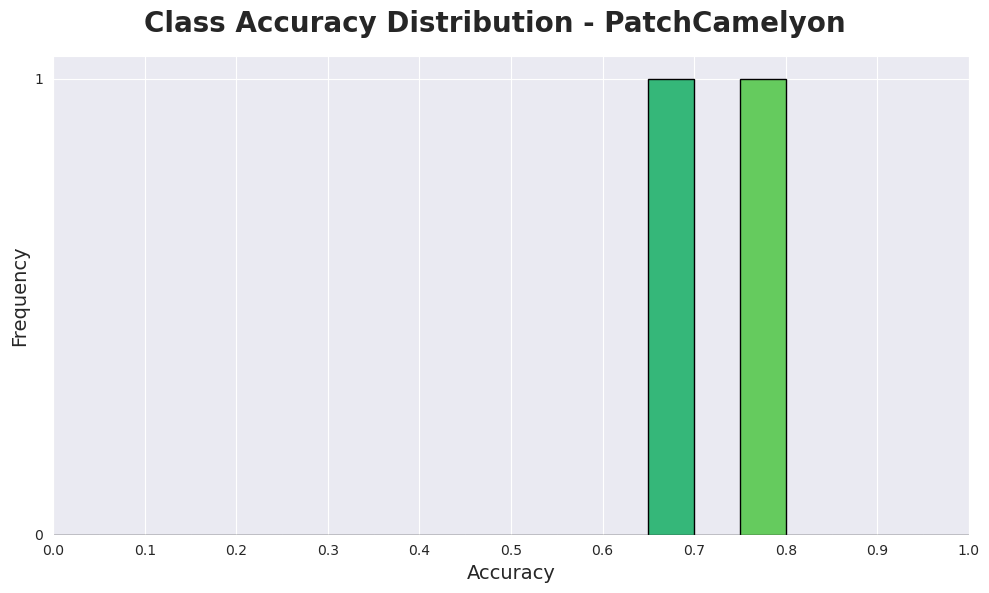

In [304]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [305]:
vit_sun397_16 = Backbone(model_names['ViT'], num_classes=len(sun397_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [306]:
get_model_params(vit_sun397_16)

Parameters: 86.10M


In [307]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    vit_sun397_16,
    sun397_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 794/794 [01:21<00:00,  9.75it/s]


Epochs: 1/10 | train_loss: 2.4479 | train_acc: 0.4972


100%|██████████| 794/794 [01:20<00:00,  9.90it/s]


Epochs: 2/10 | train_loss: 0.5302 | train_acc: 0.8471


100%|██████████| 794/794 [01:19<00:00,  9.94it/s]


Epochs: 3/10 | train_loss: 0.2161 | train_acc: 0.9422


100%|██████████| 794/794 [01:20<00:00,  9.92it/s]


Epochs: 4/10 | train_loss: 0.1089 | train_acc: 0.9721


100%|██████████| 794/794 [01:20<00:00,  9.92it/s]


Epochs: 5/10 | train_loss: 0.0547 | train_acc: 0.9890


100%|██████████| 794/794 [01:19<00:00,  9.94it/s]


Epochs: 6/10 | train_loss: 0.0292 | train_acc: 0.9951


100%|██████████| 794/794 [01:19<00:00,  9.95it/s]


Epochs: 7/10 | train_loss: 0.0290 | train_acc: 0.9948


100%|██████████| 794/794 [01:19<00:00,  9.93it/s]


Epochs: 8/10 | train_loss: 0.0174 | train_acc: 0.9975


100%|██████████| 794/794 [01:20<00:00,  9.92it/s]


Epochs: 9/10 | train_loss: 0.0173 | train_acc: 0.9967


100%|██████████| 794/794 [01:19<00:00,  9.94it/s]

Epochs: 10/10 | train_loss: 0.0274 | train_acc: 0.9932


In [308]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    vit_sun397_16,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [04:35<00:00,  9.88it/s]


test_loss: 1.6045 | test_acc: 0.6579


In [309]:
sun397_accs.append(sun397_acc)

In [311]:
get_top_5_accuracies(sun397_per_class_acc)

[('batters box', 1.0),
 ('bullring', 1.0),
 ('greenhouse (outdoor)', 1.0),
 ('oast house', 1.0),
 ('promenade deck', 1.0)]

In [312]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('power plant (outdoor)', 0.03333333333333333),
 ('bar', 0.10884353741496598),
 ('recreation room', 0.1111111111111111),
 ('fastfood restaurant', 0.12195121951219512),
 ('museum (indoor)', 0.12280701754385964)]

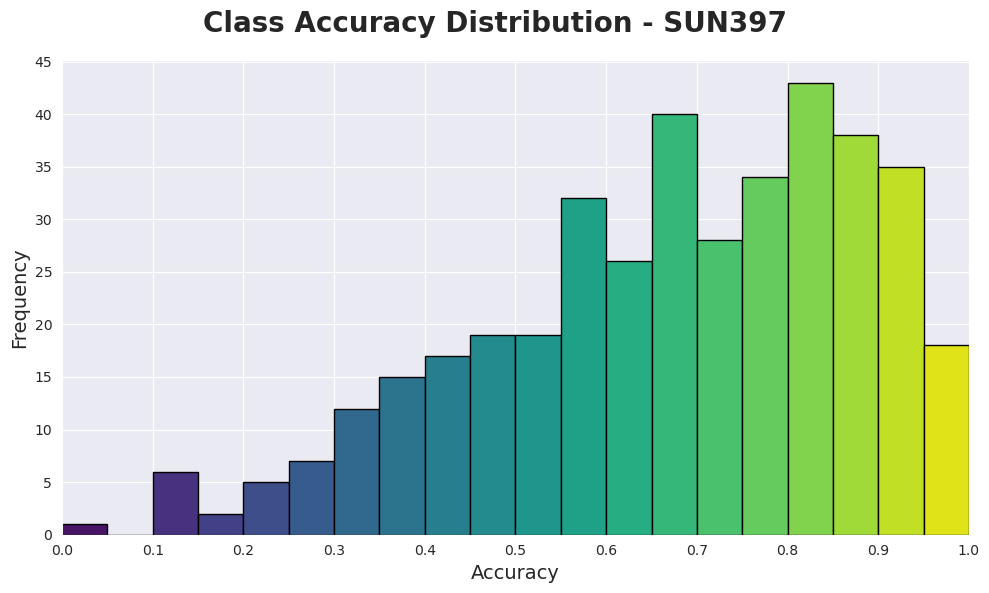

In [313]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [314]:
vit_dtd_16 = Backbone(model_names['ViT'], num_classes=len(dtd_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [315]:
get_model_params(vit_dtd_16)

Parameters: 85.83M


In [316]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    vit_dtd_16,
    dtd_train,
    config,
    'ViT',
    use_val=False,
    fine_tune=False,
    few_shot=16
)

100%|██████████| 94/94 [00:09<00:00,  9.59it/s]


Epochs: 1/10 | train_loss: 2.8742 | train_acc: 0.3378


100%|██████████| 94/94 [00:09<00:00,  9.58it/s]


Epochs: 2/10 | train_loss: 1.0347 | train_acc: 0.7886


100%|██████████| 94/94 [00:09<00:00,  9.60it/s]


Epochs: 3/10 | train_loss: 0.5098 | train_acc: 0.9282


100%|██████████| 94/94 [00:09<00:00,  9.55it/s]


Epochs: 4/10 | train_loss: 0.2765 | train_acc: 0.9747


100%|██████████| 94/94 [00:09<00:00,  9.63it/s]


Epochs: 5/10 | train_loss: 0.1672 | train_acc: 0.9947


100%|██████████| 94/94 [00:09<00:00,  9.60it/s]


Epochs: 6/10 | train_loss: 0.1131 | train_acc: 0.9987


100%|██████████| 94/94 [00:09<00:00,  9.63it/s]


Epochs: 7/10 | train_loss: 0.0822 | train_acc: 1.0000


100%|██████████| 94/94 [00:09<00:00,  9.65it/s]


Epochs: 8/10 | train_loss: 0.0633 | train_acc: 1.0000


100%|██████████| 94/94 [00:09<00:00,  9.48it/s]


Epochs: 9/10 | train_loss: 0.0502 | train_acc: 1.0000


100%|██████████| 94/94 [00:09<00:00,  9.60it/s]

Epochs: 10/10 | train_loss: 0.0414 | train_acc: 1.0000


In [317]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    vit_dtd_16,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:22<00:00, 10.24it/s]

test_loss: 1.4928 | test_acc: 0.5947


In [318]:
dtd_accs.append(dtd_acc)

In [320]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 0.95),
 ('cobwebbed', 0.925),
 ('potholed', 0.925),
 ('knitted', 0.875),
 ('paisley', 0.875)]

In [321]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('woven', 0.225),
 ('blotchy', 0.25),
 ('pitted', 0.25),
 ('stained', 0.275),
 ('flecked', 0.325)]

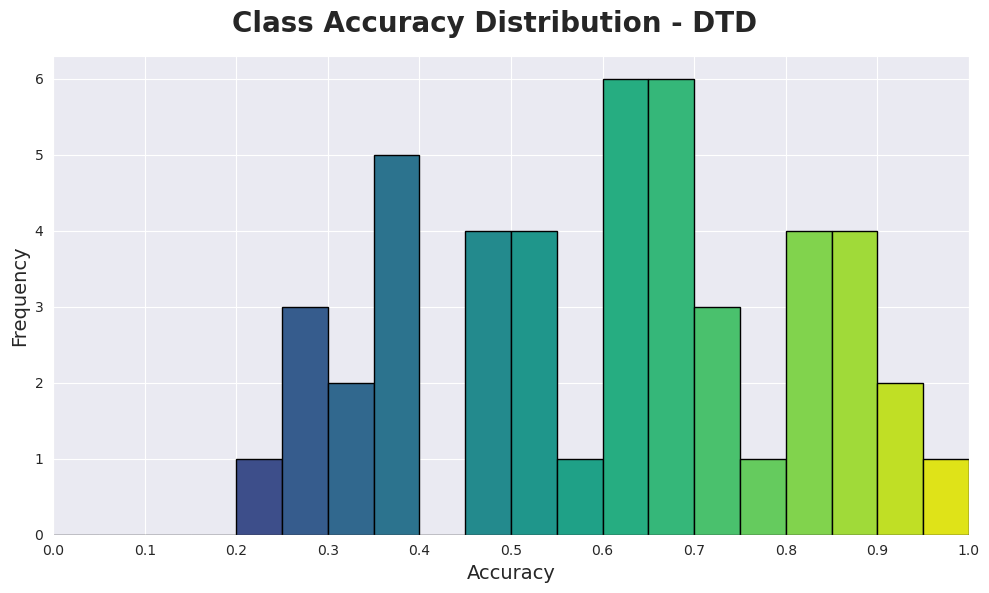

In [322]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Results

Display the results of the analysis in dataframe.

In [7]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [8]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']
n_shots = [1, 2, 4, 8, 16]

In [9]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

In [10]:
df = pd.DataFrame(results, columns=[f"{n}-shot linear probe" for n in n_shots], index=labels)
df

,1-shot linear probe,2-shot linear probe,4-shot linear probe,8-shot linear probe,16-shot linear probe
RESISC45,0.281587,0.386667,0.531905,0.616190,0.691746
Food-101,0.405149,0.536436,0.654970,0.717149,0.756554
FER2013,0.308721,0.309557,0.311507,0.309557,0.419615
PatchCamelyon,0.302277,0.372742,0.468689,0.720123,0.717987
SUN397,0.427800,0.534300,0.612500,0.659816,0.657885
DTD,0.270213,0.361170,0.456915,0.521809,0.594681
